In [2]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

PATH_TO_ATTENTION_MAPS = '/media/data/alberto/attention_scores/'
PATH_TO_XML = '/media/data/alberto/xmls/'

In [3]:
def remove_top_right_frame(ax):
    '''Remove top and right parts of the figure frame. Takes an 'ax' object as input from plt.subplots.'''
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    return 

def name_agent_list(agent_order):
    """Return list of name given a agent list

    Args:
        agent_order (list of str): List of agent

    Returns:
        list of str: Name related to each agent
    """
    name_order = [agent_title_dict[agent] for agent in agent_order]
    return name_order

def name_algo_list(algo_order):
    """Return list of name given an algorithm list

    Args:
        agent_order (list of str): List of algorithm

    Returns:
        list of str: Name related to each algorithm
    """
    name_order = [algo_legend_dict[algo] for algo in algo_order]
    return name_order

def color_list(algo_order):
    """Return list of colors related to an algorithm list

    Args:
        agent_order (list of str): List of algorithm

    Returns:
        list of str: Color related to each algorithm
    """
    color_order = [algo_colormap_dict[algo](0.5) for algo in algo_order]
    return color_order

def color_list_hue(algo_order,sigma_order):
    """Return list of colors related to an algorithm list

    Args:
        agent_order (list of str): List of algorithm

    Returns:
        list of str: Color related to each algorithm
    """
    color_order = [[algo_colormap_dict[algo](sigma_idx_dict[sigma[-2:]]) for sigma in sigma_order] for algo in algo_order]
    # sigma_order = [algo_colormap_dict[algo](0.5) for algo in algo_order]
    return color_order

In [4]:
params = {
   'axes.labelsize': 18,
   'legend.fontsize': 15,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
   'text.usetex': False,
   'figure.figsize': [7,7],
   'font.size': 18,
    'lines.markersize':10,
   }

plt.rcParams.update(params)

algo_colormap_dict = {
    "adapted": plt.cm.Oranges,
    "simple": plt.cm.Blues,
    "oracle": plt.cm.Reds,
    "attention": plt.cm.Greens,
    "convnet": plt.cm.Purples
}
sigma_idx_dict = {
    "01": 130,
    "03": 180,
    "05": 210
}
algo_legend_dict = {
    "simple": "Simple",
    "oracle": "Oracle",
    "attention": "BAD (ours)",
    "convnet": "TCN",
    "adapted": "TCN adapt"
}

sigma_legend_dict = {
    "01": "$\sigma = 0.1$",
    "03": "$\sigma = 0.3$",
    "05": "$\sigma = 0.5$",    
}

agent_title_dict = {
    "hopper": "Hopper",
    "walker": "Walker",
    "ant": "Ant",
    "half_cheetah": "Half Cheetah"
}


### Agent component

In [5]:
state_components = [
    "z",
    "sin(angle_to_target)",
    "cos(angle_to_target)",
    "vx",
    "vy",
    "vz",
    "r",
    "p",
    "hip_back_left_angle",
    "hip_back_left_velocity",
    "ankle_back_left_angle",
    "ankle_back_left_velocity",
    "hip_front_left_angle",
    "hip_front_left_velocity",
    "ankle_front_left_angle",
    "ankle_front_left_velocity",
    "hip_back_right_angle",
    "hip_back_right_velocity",
    "ankle_back_right_angle",
    "ankle_back_right_velocity",
    "hip_front_right_angle",
    "hip_front_right_velocity",
    "ankle_front_right_angle",
    "ankle_front_right_velocity",
    "back_left_foot_contact",
    "front_left_foot_contact",
    "back_right_foot_contact",
    "front_right_foot_contact"
]

action_components = [
    "hip_back_left_torque",
    "ankle_back_left_torque",
    "hip_front_left_torque",
    "ankle_front_left_torque",
    "hip_back_right_torque",
    "ankle_back_right_torque",
    "hip_front_right_torque",
    "ankle_front_right_torque"
]

### Load the data

In [6]:
import json
 
agent_list = ['ant', 'half_cheetah', 'hopper', 'walker']

agent = 'ant'
seed = '1'

file_name_list = os.listdir(PATH_TO_ATTENTION_MAPS)


# file_name = [file_name for file_name in file_name_list if agent+'_seed_'+seed in file_name]
file_name = [file_name for file_name in file_name_list if (agent+'_seed_'+seed in file_name) and ('_checkpoint_' not in file_name)]

path_to_file = os.path.join(PATH_TO_ATTENTION_MAPS,file_name[0])

# Opening JSON file
f = open(path_to_file)
 
# returns JSON object as a dictionary
data = json.load(f)
 
# Closing file
f.close()

FileNotFoundError: [Errno 2] No such file or directory: '/media/data/alberto/attention_scores/'

In [6]:
### Select sigma to load
test_sigma = 'test_sigma_01'
sigma = test_sigma[-8:]

In [7]:
### CHECK PERTURBATION for a specific xml file

file_name_list = os.listdir(PATH_TO_XML)

file_name = [file_name for file_name in file_name_list if agent in file_name]

path_to_file = os.path.join(PATH_TO_XML,file_name[0])
path_to_file = os.path.join(path_to_file,test_sigma,'perturbation_summary.pkl')

perturbation_summary = pd.read_pickle(path_to_file)

In [8]:
def get_attention_based_on_contact(attention_episode,ind_contact_on,ind_contact_off):
    """Return attention only during the corresponding ON and OFF contact

    Args:
        attention_episode (_type_): _description_
        ind_contact_on (_type_): _description_
        ind_contact_off (_type_): _description_
    """
    attention_episode_on = []
    attention_episode_off = []
    len_num_contact = min(len(ind_contact_on),len(ind_contact_off))
    for ii in range(len_num_contact):
        attention_episode_on.append(attention_episode[ind_contact_on[ii]:ind_contact_off[ii]])
        if ii < len(ind_contact_on) -1:
            attention_episode_off.append(attention_episode[ind_contact_off[ii]:ind_contact_on[ii+1]])
    attention_episode_on = np.vstack(attention_episode_on)
    attention_episode_off = np.vstack(attention_episode_off)
    return attention_episode_on, attention_episode_off

In [9]:
data.keys()

dict_keys(['ant_attention_sigma_01_seed_1', 'ant_attention_sigma_03_seed_1', 'ant_attention_sigma_05_seed_1'])

In [10]:
### LOAD ATTENTION FOR EACH EPISODE

attention_episode_all = []

perturbation_all = []
obs_all =[]
act_all = []

for jj in range(len(data[agent+'_attention_'+sigma+'_seed_1']['data']['/home/alberto/Dev/rl/rl-adapt/data/xmls/'+agent+'/' + test_sigma])):
    xml_idx = jj
    attention_episode = []
    obs_episode = []
    act_episode = []
    perturb_episode = []
    for ii in range(len(data[agent+'_attention_'+sigma+'_seed_1']['data']['/home/alberto/Dev/rl/rl-adapt/data/xmls/'+agent+'/' + test_sigma][xml_idx])):
        attention_scores = np.array(data[agent+'_attention_'+sigma+'_seed_1']['data']['/home/alberto/Dev/rl/rl-adapt/data/xmls/'+agent+'/' + test_sigma][xml_idx][ii]['attention'])
        obs_tmp = np.array(data[agent+'_attention_'+sigma+'_seed_1']['data']['/home/alberto/Dev/rl/rl-adapt/data/xmls/'+agent+'/' + test_sigma][xml_idx][ii]['obs'])
        act_tmp = np.array(data[agent+'_attention_'+sigma+'_seed_1']['data']['/home/alberto/Dev/rl/rl-adapt/data/xmls/'+agent+'/' + test_sigma][xml_idx][ii]['action'])
        perturbation_values = np.array(perturbation_summary['values'])[xml_idx,:]

        perturb_episode.append(perturbation_values)
        attention_episode.append(attention_scores)
        obs_episode.append(obs_tmp)
        act_episode.append(act_tmp)
    
    perturb_episode = np.stack(perturb_episode)
    attention_episode = np.stack(attention_episode)

    ## Remove episode that didn't reach 1000 timesteps
    if attention_episode.shape[0] == 1000:
        attention_episode_all.append(attention_episode)

        perturbation_all.append(perturb_episode)
        obs_all.append(obs_episode)
        act_all.append(act_episode)

attention_episode_all_stack = np.stack(attention_episode_all)
attention_episode_all = np.vstack(attention_episode_all)
perturbation_all = np.stack(perturbation_all)
obs_all = np.stack(obs_all)
act_all = np.stack(act_all)

### Dynamic attention

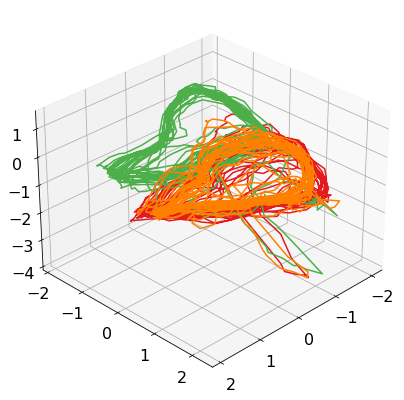

In [11]:
# from sklearn.decomposition import PCA
# from deeptime.decomposition import VAMP, TICA
# import matplotlib as mpl

# vamp = VAMP(dim=3, lagtime=1)
# # projected = pca.fit_transform(attention_episode.reshape(attention_episode.shape[0],-1))

# ### Fit on all time points
# fitted = vamp.fit(attention_episode_all_stack.reshape(-1,attention_episode_all_stack.shape[2]*attention_episode_all_stack.shape[3]))

# n_projection = 3
# ind_start = 0

# cmap = mpl.colormaps['Set1']  #Set1
# colors = cmap(np.linspace(0,0.5,n_projection))
# # colors = plt.cm.jet(np.linspace(0,1,n_projection))
# projected_all = []
# for ii in range(n_projection):
#     projected = fitted.transform(attention_episode_all_stack[ii,:,:,:].reshape(attention_episode_all_stack.shape[1],-1))
#     projected_all.append(projected)

# fig = plt.figure()
# ax = plt.axes(projection='3d')

# for ii in range(n_projection):
#     projected = projected_all[ii]
#     ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],color = colors[ii])
# ax.view_init(elev=30., azim=45)


/home/alessandro/anaconda3/envs/rl_adapt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alessandro/anaconda3/envs/rl_adapt/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


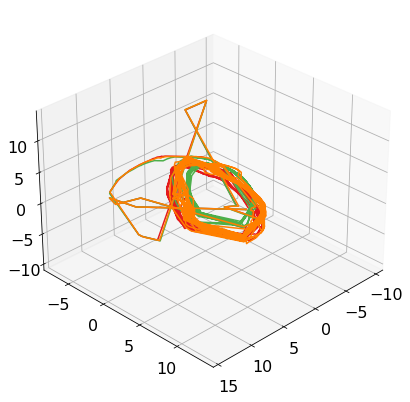

In [11]:
import umap
import matplotlib as mpl
umap_red = umap.UMAP(n_components=3,random_state=42)
# projected = pca.fit_transform(attention_episode.reshape(attention_episode.shape[0],-1))

### Fit on all time points
fitted = umap_red.fit(attention_episode_all_stack.reshape(-1,attention_episode_all_stack.shape[2]*attention_episode_all_stack.shape[3]))

n_projection = 3
ind_start = 0

cmap = mpl.colormaps['Set1']
colors = cmap(np.linspace(0,0.5,n_projection))
# colors = plt.cm.jet(np.linspace(0,1,n_projection))
projected_all = []
for ii in range(n_projection):
    projected = fitted.transform(attention_episode_all_stack[ii,:,:,:].reshape(attention_episode_all_stack.shape[1],-1))
    projected_all.append(projected)

fig = plt.figure()
ax = plt.axes(projection='3d')

for ii in range(n_projection):
    projected = projected_all[ii]
    ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],color = colors[ii])
ax.view_init(elev=30., azim=45)


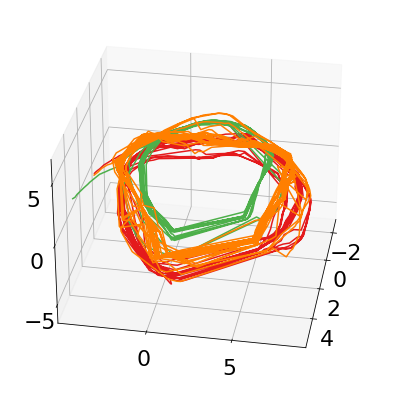

In [71]:
ind_start = 40
fig = plt.figure()
ax = plt.axes(projection='3d')

for ii in range(n_projection):
    projected = projected_all[ii]
    ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],color = colors[ii])
ax.view_init(elev=30., azim=10)

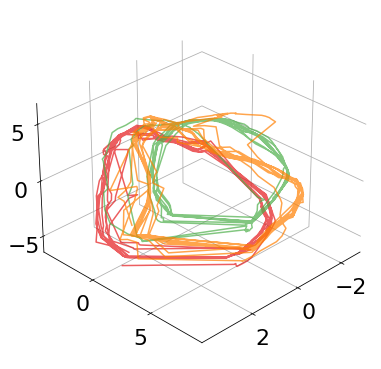

In [103]:
import matplotlib.patches as mpatches

save_flag = True

PATH_TO_FIG = '../figures/'

if save_flag:
    if not os.path.exists(PATH_TO_FIG):
        os.makedirs(PATH_TO_FIG)

params = {
   'axes.labelsize': 26,
   'legend.fontsize': 24,
   'xtick.labelsize': 22, #28,
   'ytick.labelsize': 22, #28,
#    'ztick.labelsize': 26,
   'text.usetex': False,
   'figure.figsize': [7,7],
   'font.size': 24,
    'lines.markersize':10,
   }

plt.rcParams.update(params)


ind_start = 80
ind_end = 500

fig = plt.figure(figsize=[14,14])
# ax = plt.axes(projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')

handles_list = []
for ii in range(n_projection):
    projected = projected_all[ii]
    ax.plot(projected[ind_start:ind_end,0],projected[ind_start:ind_end,1],projected[ind_start:ind_end,2],color = colors[ii],alpha=0.7,label='Morph. '+str(ii))
    handles_list.append(mpatches.Patch(color=colors[ii], label='Morph. '+str(ii+1)))
ax.view_init(elev=30., azim=45)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='z', nbins=5)

# plt.legend()
# right_side.set_visible(False)
# ax.view_init(elev=00., azim=90)

# fig.legend(handles=handles_list,frameon=True, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=24)
# fig.tight_layout()


if save_flag:
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap_morphologies2.png', format='png', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap_morphologies2.pdf', format='pdf', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap_morphologies2.svg', format='svg', dpi=600, bbox_inches='tight')

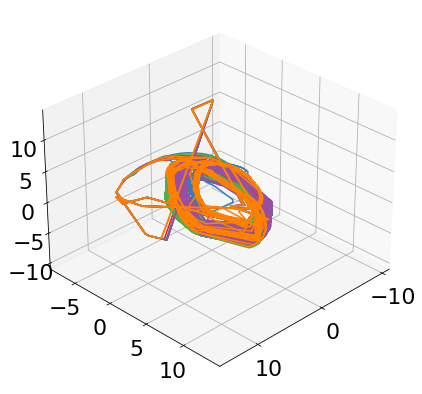

In [136]:
n_projection = 10
ind_start = 0

cmap = mpl.colormaps['Set1']
colors = cmap(np.linspace(0,0.5,n_projection))
# colors = plt.cm.jet(np.linspace(0,1,n_projection))
projected_all = []
for ii in range(n_projection):
    projected = fitted.transform(attention_episode_all_stack[ii,:,:,:].reshape(attention_episode_all_stack.shape[1],-1))
    projected_all.append(projected)

fig = plt.figure()
ax = plt.axes(projection='3d')

for ii in range(n_projection):
    projected = projected_all[ii]
    ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],color = colors[ii])
ax.view_init(elev=30., azim=45)

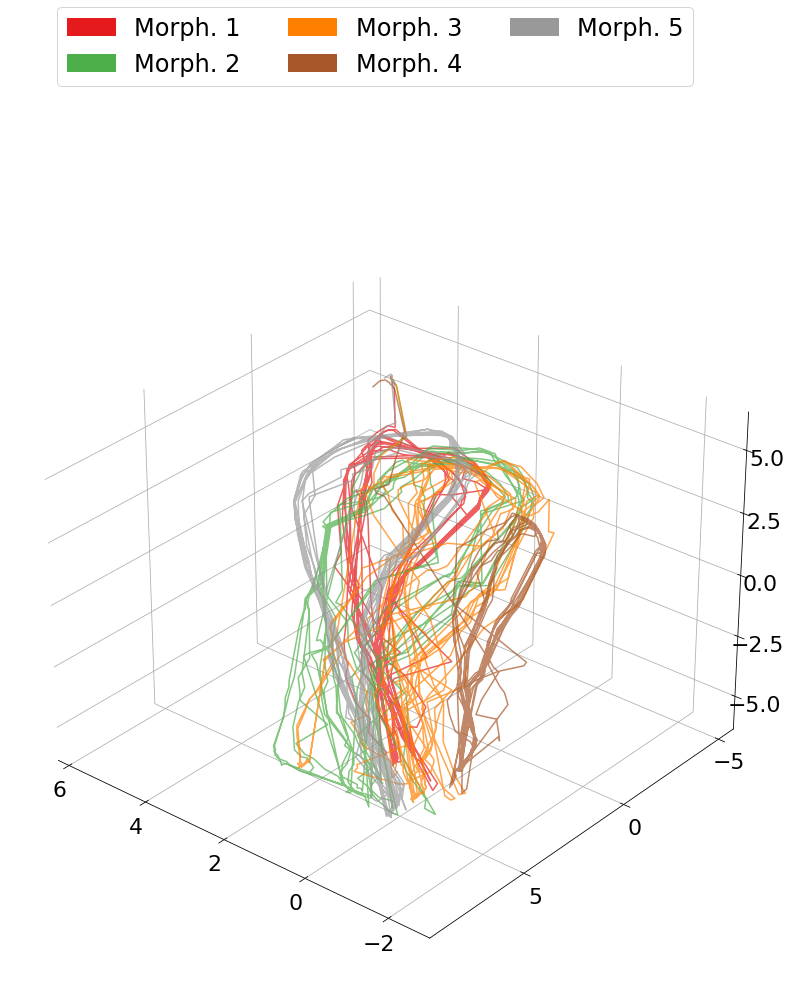

In [142]:
fig = plt.figure(figsize=[14,14])
ax = plt.axes(projection='3d')
# ax = fig.add_subplot(1, 2, 1, projection='3d')

ind_start = 40

n_projection = 5

cmap = mpl.colormaps['Set1']
colors = cmap(np.linspace(0,1,n_projection))

handles_list = []
for ii in range(n_projection):
    projected = projected_all[ii+5]
    ax.plot(projected[ind_start:ind_end,0],projected[ind_start:ind_end,1],projected[ind_start:ind_end,2],color = colors[ii],alpha=0.7,label='Morph. '+str(ii))
    handles_list.append(mpatches.Patch(color=colors[ii], label='Morph. '+str(ii+1)))
ax.view_init(elev=30., azim=130)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='z', nbins=5)
fig.legend(handles=handles_list,frameon=True, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=24)

In [ ]:
# projected_all_obs

In [217]:
def measure_tangling(data):
    derivative = np.gradient(data,axis=0)

    epsilon = 0.1*np.mean(np.linalg.norm(data,axis=1))
    Q_all = []
    for t in range(derivative.shape[0]):
        Q = (np.linalg.norm(derivative[t] - derivative,axis=1)**2) / (epsilon + np.linalg.norm(data[t] - data,axis=1)**2)
        Q = np.max(Q)
        Q_all.append(Q)
    

    return Q_all, Q #np.max(Q), np.argmax(Q)


ind_start = 100
ii = 0
projected = projected_all[ii]
print(projected.shape)

max_q_att, ind_max_q_att = measure_tangling(projected[ind_start:])

# print(max_q_att)


projected_obs = projected_all_obs[ii]
print(projected.shape)

max_q_obs, ind_max_q_obs = measure_tangling(projected_obs[ind_start:])

# print(max_q_obs)

# print(max_q_att - max_q_att)

# proj_tangl = measure_tangling(projected)

# derivative = np.gradient(projected,axis=0)
# print(derivative.shape)


# epsilon = 0.1*np.mean(np.linalg.norm(projected,axis=1))


# Q = (np.linalg.norm(derivative,axis=1)**2) / (epsilon + np.linalg.norm(projected,axis=1)**2)

# print(np.argmax(Q))

# print(np.linalg.norm(derivative,axis=1).shape)

# plt.figure()
# plt.plot(derivative[:,0])

# plt.figure()
# plt.plot(derivative[:,1])

(1000, 3)
(1000, 3)


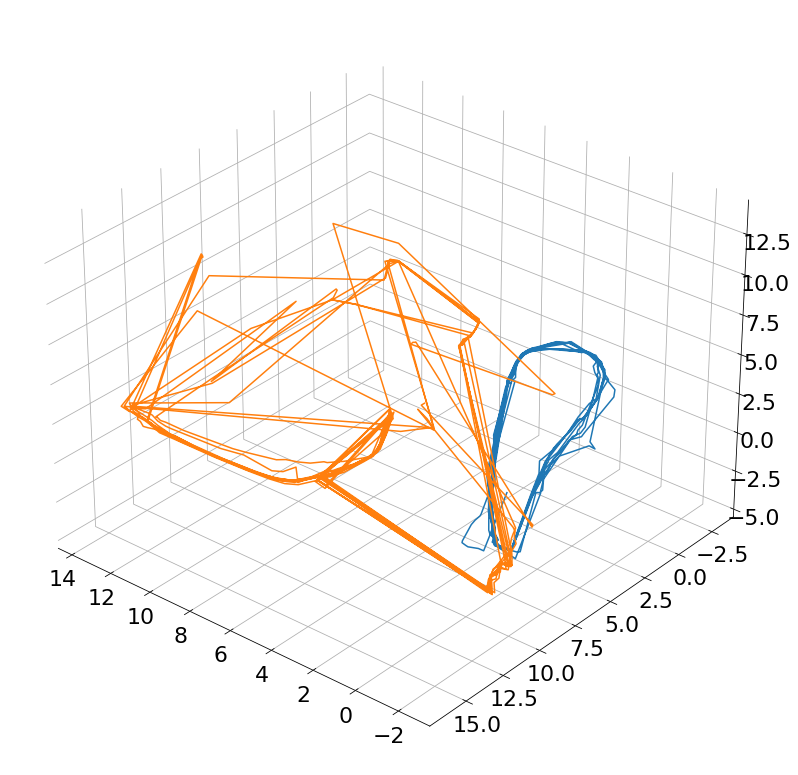

In [205]:
fig = plt.figure(figsize=[14,14])
ax = plt.axes(projection='3d')
# ax = fig.add_subplot(1, 2, 1, projection='3d')

ind_start = 100

n_projection = 3

cmap = mpl.colormaps['Set1']
colors = cmap(np.linspace(0,0.5,n_projection))

projected = projected_all[ii]
ax.plot(projected[ind_start:ind_end,0],projected[ind_start:ind_end,1],projected[ind_start:ind_end,2])

projected = projected_all_obs[ii]
ax.plot(projected[ind_start:ind_end,0],projected[ind_start:ind_end,1],projected[ind_start:ind_end,2])


ax.view_init(elev=30., azim=130)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

In [201]:
np.where(np.array(max_q_att)>0.8)

(array([ 22, 279, 315, 316, 398, 399, 522, 523, 604, 605, 686]),)

(0.0, 100.0)

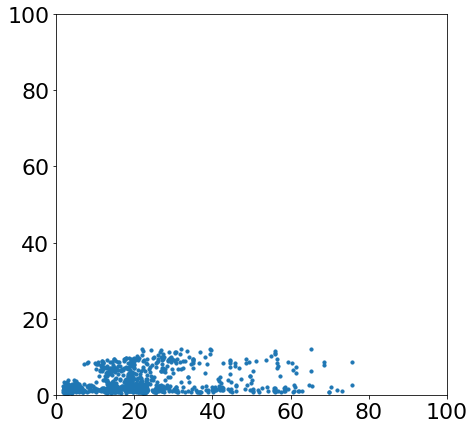

In [220]:
plt.figure()
plt.scatter(max_q_obs, max_q_att,s=10)
plt.xlim(0,100)
plt.ylim(0,100)

In [143]:
len(projected_all_obs)

3

In [149]:
perturbation_summary['values'][0]

[-0.06039208582682565,
 -0.02863531698369043,
 -0.0883700189501667,
 0.040567299059667355,
 -0.07674055615893353,
 0.07637571047544711,
 0.04896325916705218,
 -0.013245526514070627,
 -0.022817563635333972]

In [156]:
attention_episode_all_stack.shape

(100, 1000, 8, 36)

In [157]:
projected_all = []
for ii in range(attention_episode_all_stack.shape[0]):
    projected = fitted.transform(attention_episode_all_stack[ii,:,:,:].reshape(attention_episode_all_stack.shape[1],-1))
    projected_all.append(projected)

In [184]:
n_projections_dist = attention_episode_all_stack.shape[0]

ind_start = 150

ind_1 = 0
all_distance = []
all_perturb_int = []
for ii in range(1,n_projections_dist):
    ind_2 = ii
    projection_conc = np.concatenate([projected_all[ind_1][ind_start:],projected_all[ind_2][ind_start:]])
    # print(projection_conc.shape)
    labels = np.concatenate([np.ones_like(projected_all[ind_1][ind_start:,0]),2*np.ones_like(projected_all[ind_2][ind_start:,0])])

    attent_dist = silhouette_score(projection_conc, labels)

    perturb_intensity_0 = np.array(perturbation_summary['values'][ind_1])
    perturb_intensity_tmp = np.array(perturbation_summary['values'][ii])
    perturb_intensity_diff = np.linalg.norm(perturb_intensity_tmp - perturb_intensity_0)

    all_distance.append(attent_dist)
    all_perturb_int.append(perturb_intensity_diff)

all_distance = np.stack(all_distance)
all_perturb_int = np.stack(all_perturb_int)

In [166]:
idx = np.argpartition(all_distance, 20)
print(idx)

[70 68 39 32 73 94 20 47 69 37 42 29 97 66  5 80 98 16 87 34 81 72 21  8
 24 41 57 18 17 43 96 10  3 61 54 33 31 28 71  2 56 25 19 14 11 26 74 85
 48  1 50 51 84 83 45 55 91 92 58 82 36 93 30 79 77 76 23 67 22 95 13  9
  6  4 75 49 65 64 78 63 62 60 59 53 52 46 86 44 88 89 90 40 38 35 27 15
 12  7  0]


In [172]:
ind_max_of_min_array = np.argmax(all_perturb_int[idx])
print(ind_max_of_min_array)
print(idx[ind_max_of_min_array])

51
51


In [178]:
idx = np.argpartition(all_distance, 20)[::-1]
print(idx)

[ 0  7 12 15 27 35 38 40 90 89 88 44 86 46 52 53 59 60 62 63 78 64 65 49
 75  4  6  9 13 95 22 67 23 76 77 79 30 93 36 82 58 92 91 55 45 83 84 51
 50  1 48 85 74 26 11 14 19 25 56  2 71 28 31 33 54 61  3 10 96 43 17 18
 57 41 24  8 21 72 81 34 87 16 98 80  5 66 97 29 42 37 69 47 20 94 73 32
 39 68 70]


In [173]:
all_perturb_int[51]

0.3237263917587365

In [174]:
all_distance[51]

0.022927798

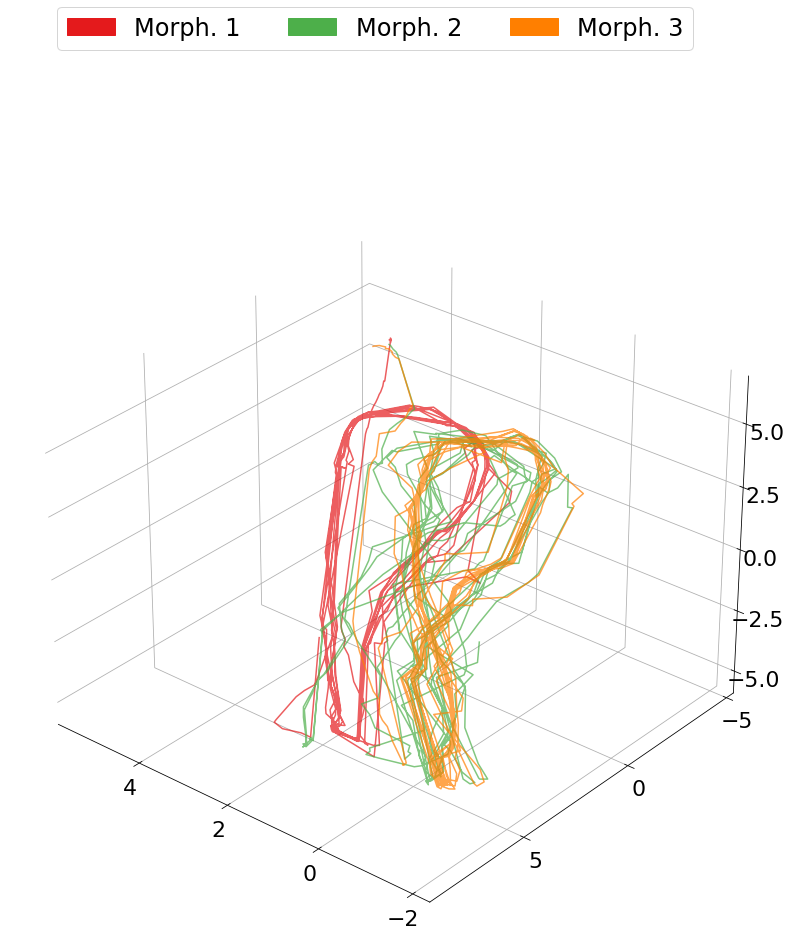

In [182]:
fig = plt.figure(figsize=[14,14])
ax = plt.axes(projection='3d')
# ax = fig.add_subplot(1, 2, 1, projection='3d')

ind_start = 40

n_projection = 3

cmap = mpl.colormaps['Set1']
colors = cmap(np.linspace(0,0.5,n_projection))

list_index = [0,7,51]

handles_list = []
for ii in range(n_projection):
    projected = projected_all[list_index[ii]]
    ax.plot(projected[ind_start:ind_end,0],projected[ind_start:ind_end,1],projected[ind_start:ind_end,2],color = colors[ii],alpha=0.7,label='Morph. '+str(ii))
    handles_list.append(mpatches.Patch(color=colors[ii], label='Morph. '+str(ii+1)))
ax.view_init(elev=30., azim=130)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='z', nbins=5)
fig.legend(handles=handles_list,frameon=True, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=24)

Text(0.5, 0, 'Morphology distance')

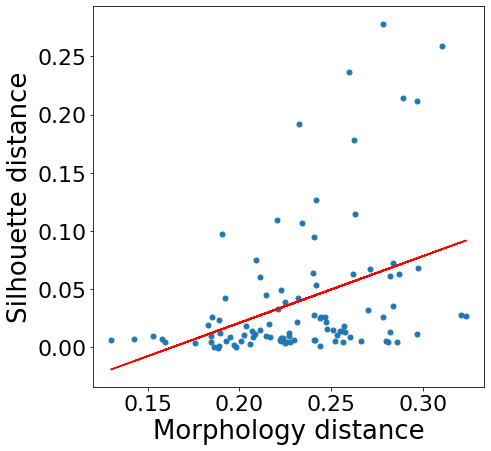

In [186]:
plt.figure()
plt.plot(all_perturb_int,all_distance,'.')

a, b = np.polyfit(all_perturb_int, all_distance, 1)

plt.plot(all_perturb_int, a*all_perturb_int+b,'r') 

plt.ylabel('Silhouette distance')
plt.xlabel('Morphology distance')

In [226]:
obs_all.shape[0]

100

In [227]:
projected_all_obs = []
for ii in range(obs_all.shape[0]):
    projected_obs = fitted_obs.transform(obs_all[ii,:,:,:].reshape(obs_all.shape[1],-1))
    projected_all_obs.append(projected_obs)

In [242]:
from sklearn.metrics import silhouette_score

ind_start = 100
ind_1 = 1
ind_2 = 80

attent_dist_all = []
obs_dist_all = []
for ind_2 in range(obs_all.shape[0]):

    if ind_2 != ind_1:
        projection_conc = np.concatenate([projected_all[ind_1][ind_start:],projected_all[ind_2][ind_start:]])
        # print(projection_conc.shape)
        labels = np.concatenate([np.ones_like(projected_all[ind_1][ind_start:,0]),2*np.ones_like(projected_all[ind_2][ind_start:,0])])

        # print(labels.shape)

        attent_dist = silhouette_score(projection_conc, labels)


        projection_conc = np.concatenate([projected_all_obs[ind_1][ind_start:],projected_all_obs[ind_2][ind_start:]])
        # print(projection_conc.shape)
        labels = np.concatenate([np.ones_like(projected_all_obs[ind_1][ind_start:,0]),2*np.ones_like(projected_all_obs[ind_2][ind_start:,0])])

        obs_dist = silhouette_score(projection_conc, labels)

        attent_dist_all.append(attent_dist)
        obs_dist_all.append(obs_dist)

attent_dist_all = np.stack(attent_dist_all)
obs_dist_all = np.stack(obs_dist_all)
print(attent_dist, obs_dist)



0.103361584 0.038681526


In [251]:
from sklearn.metrics import silhouette_score

ind_start = 100
ind_1 = 1
ind_2 = 80

attent_dist_all = []
obs_dist_all = []

for ind_1 in range(obs_all.shape[0]):
    attent_dist_all1 = []
    obs_dist_all1 = []
    all_index = [ind_tmp for ind_tmp in range(obs_all.shape[0]) if ind_tmp != ind_1]
    ind_obs_tmp = np.random.choice(all_index, 10)
    for ind_2 in ind_obs_tmp:

        projection_conc = np.concatenate([projected_all[ind_1][ind_start:],projected_all[ind_2][ind_start:]])
        # print(projection_conc.shape)
        labels = np.concatenate([np.ones_like(projected_all[ind_1][ind_start:,0]),2*np.ones_like(projected_all[ind_2][ind_start:,0])])

        # print(labels.shape)

        attent_dist = silhouette_score(projection_conc, labels)


        projection_conc = np.concatenate([projected_all_obs[ind_1][ind_start:],projected_all_obs[ind_2][ind_start:]])
        # print(projection_conc.shape)
        labels = np.concatenate([np.ones_like(projected_all_obs[ind_1][ind_start:,0]),2*np.ones_like(projected_all_obs[ind_2][ind_start:,0])])

        obs_dist = silhouette_score(projection_conc, labels)

        attent_dist_all1.append(attent_dist)
        obs_dist_all1.append(obs_dist)
    attent_dist_all.append(attent_dist_all1)
    obs_dist_all.append(obs_dist_all1)
    

attent_dist_all = np.stack(attent_dist_all)
obs_dist_all = np.stack(obs_dist_all)
print(attent_dist, obs_dist)

0.0067214184 0.0066355937


In [249]:
attent_dist_all.shape

(5, 10)

In [253]:
save_flag = False

PATH_TO_FIG = '../figures/'

if save_flag:
    if not os.path.exists(PATH_TO_FIG):
        os.makedirs(PATH_TO_FIG)

In [254]:
def remove_top_right_frame(ax):
    '''Remove top and right parts of the figure frame. Takes an 'ax' object as input from plt.subplots.'''
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    return 

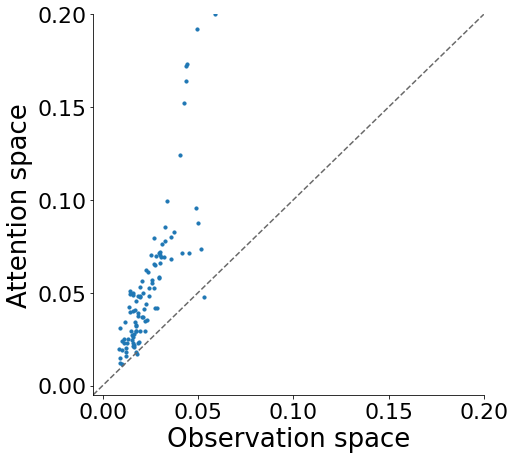

In [255]:


mean_obs_dist_all = np.mean(obs_dist_all,axis=1)
mean_attent_dist_all = np.mean(attent_dist_all,axis=1)
max_all = np.max([np.max(mean_obs_dist_all), np.max(mean_attent_dist_all)])


params = {
   'axes.labelsize': 26,
   'legend.fontsize': 24,
   'xtick.labelsize': 22,
   'ytick.labelsize': 22,
   'text.usetex': False,
   'figure.figsize': [7,7],
   'font.size': 26,
    'lines.markersize':10,
   }

plt.rcParams.update(params)


fig,ax = plt.subplots()
plt.scatter(mean_obs_dist_all, mean_attent_dist_all,s=10)
plt.xlabel('Observation space')
plt.ylabel('Attention space')
plt.xlim(-0.005,max_all)
plt.ylim(-0.005,max_all)
plt.axline((1, 1), slope=1, ls='--', color='dimgray', alpha=1.0, label='')
remove_top_right_frame(ax)

if save_flag:
    plt.savefig(PATH_TO_FIG + 'silhouette_morphologies.png', format='png', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'silhouette_morphologies.pdf', format='pdf', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'silhouette_morphologies.svg', format='svg', dpi=600, bbox_inches='tight')

In [245]:
ind_1 = 0
ind_2 = 1
ind_3 = 2
ind_4 = 3
ind_5 = 4

projection_conc = np.concatenate([projected_all[ind_1][ind_start:],projected_all[ind_2][ind_start:],projected_all[ind_3][ind_start:]
                                    ,projected_all[ind_4][ind_start:],projected_all[ind_5][ind_start:]])
# print(projection_conc.shape)
labels = np.concatenate([np.ones_like(projected_all[ind_1][ind_start:,0]),2*np.ones_like(projected_all[ind_2][ind_start:,0]),3*np.ones_like(projected_all[ind_2][ind_start:,0]),
                            4*np.ones_like(projected_all[ind_2][ind_start:,0]),5*np.ones_like(projected_all[ind_2][ind_start:,0])])

# print(labels.shape)

attent_dist = silhouette_score(projection_conc, labels)
print(attent_dist)



projection_conc = np.concatenate([projected_all_obs[ind_1][ind_start:],projected_all_obs[ind_2][ind_start:],projected_all_obs[ind_3][ind_start:]
                                    ,projected_all_obs[ind_4][ind_start:],projected_all_obs[ind_5][ind_start:]])
# print(projection_conc.shape)
labels = np.concatenate([np.ones_like(projected_all[ind_1][ind_start:,0]),2*np.ones_like(projected_all[ind_2][ind_start:,0]),3*np.ones_like(projected_all[ind_2][ind_start:,0]),
                            4*np.ones_like(projected_all[ind_2][ind_start:,0]),5*np.ones_like(projected_all[ind_2][ind_start:,0])])

# print(labels.shape)

obs_dist = silhouette_score(projection_conc, labels)
print(obs_dist)

0.001463
-0.026571982


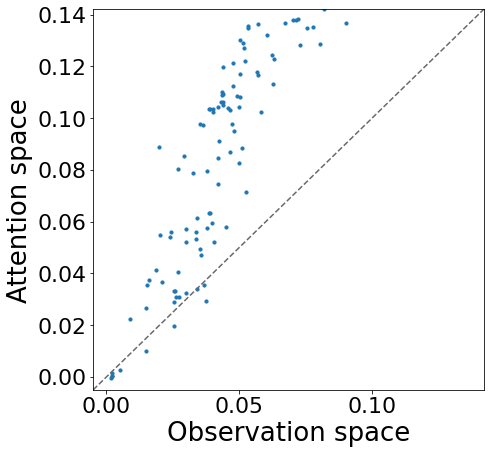

In [243]:
max_all = np.max([np.max(obs_dist_all), np.max(attent_dist_all)])
plt.figure()
plt.scatter(obs_dist_all, attent_dist_all,s=10)
plt.xlabel('Observation space')
plt.ylabel('Attention space')
plt.xlim(-0.005,max_all)
plt.ylim(-0.005,max_all)
plt.axline((1, 1), slope=1, ls='--', color='dimgray', alpha=1.0, label='')

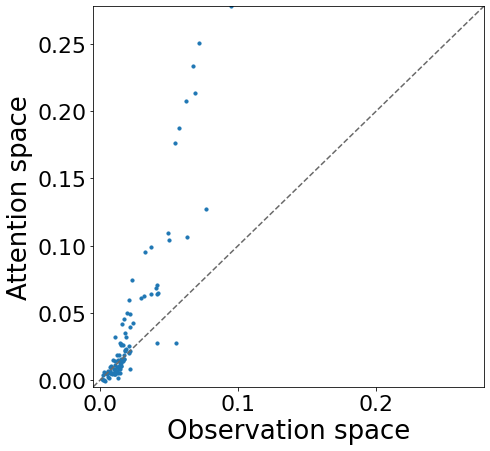

In [241]:
max_all = np.max([np.max(obs_dist_all), np.max(attent_dist_all)])
plt.figure()
plt.scatter(obs_dist_all, attent_dist_all,s=10)
plt.xlabel('Observation space')
plt.ylabel('Attention space')
plt.xlim(-0.005,max_all)
plt.ylim(-0.005,max_all)
plt.axline((1, 1), slope=1, ls='--', color='dimgray', alpha=1.0, label='')

# max_all = np.max([np.max(max_q_act), np.max(max_q_att)])
# plt.figure()
# plt.scatter(max_q_act, max_q_att,s=10)
# plt.xlabel('Action space')
# plt.ylabel('Attention space')
# plt.xlim(0,max_all)
# plt.ylim(0,max_all)
# plt.axline((1, 1), slope=1, ls='--', color='dimgray', alpha=1.0, label='')

#### Specific pose

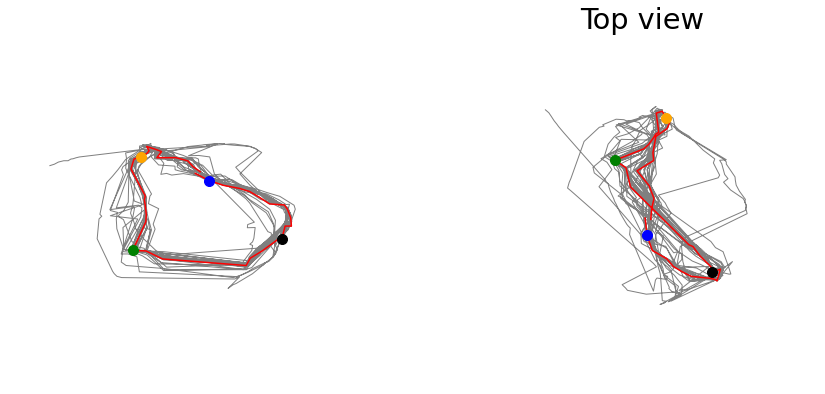

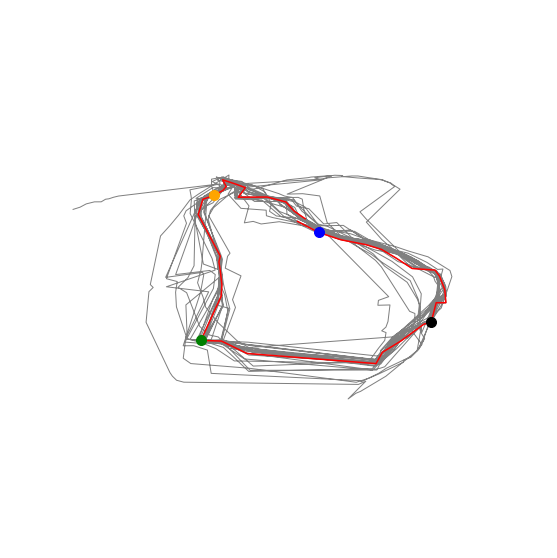

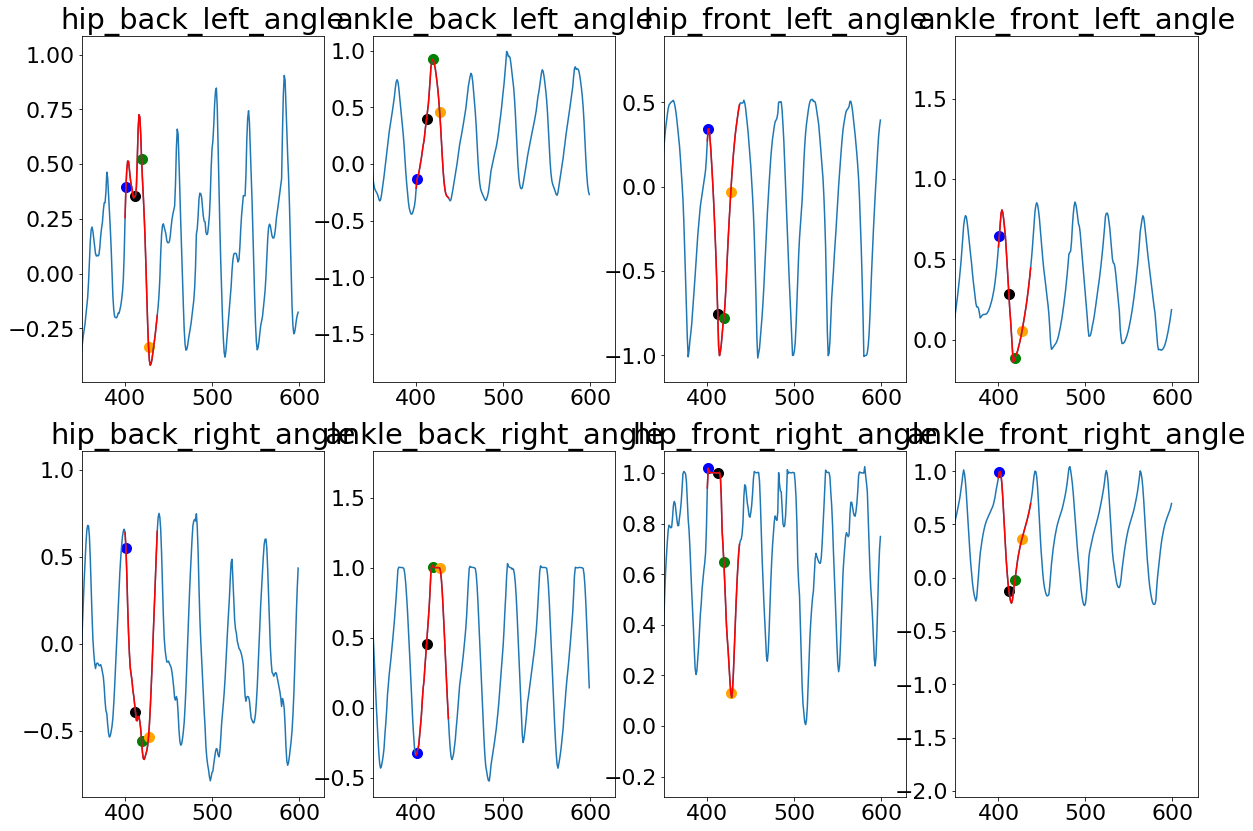

In [74]:
### Look at the dynamic wrt to observation
ind_angles = [ind for ind,state_name in enumerate(state_components) if '_angle' in state_name]
projected = projected_all[2]

ind_start = 40
ind_xml = 0
ind_time1 = 400
ind_time2 = 438

ind_angle1 = 401
ind_angle2 = 412
ind_angle3 = 419
ind_angle4 = 427

fig= plt.figure(figsize=[14,6])

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],c='gray',linewidth=1)
ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.scatter(projected[ind_angle1,0],projected[ind_angle1,1],projected[ind_angle1,2],c='blue',s=100)
ax.scatter(projected[ind_angle2,0],projected[ind_angle2,1],projected[ind_angle2,2],c='k',s=100)
ax.scatter(projected[ind_angle3,0],projected[ind_angle3,1],projected[ind_angle3,2],c='green',s=100)
ax.scatter(projected[ind_angle4,0],projected[ind_angle4,1],projected[ind_angle4,2],c='orange',s=100)

ax.set_xlabel('Proj1')
ax.set_zlabel('Proj2')
ax.set_ylabel('Proj3')
# ax.set_title('Lateral view')
ax.axis('off')
ax.view_init(elev=30., azim=45)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot3D(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],c='gray',linewidth=1)
ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.scatter(projected[ind_angle1,0],projected[ind_angle1,1],projected[ind_angle1,2],c='blue',s=100)
ax.scatter(projected[ind_angle2,0],projected[ind_angle2,1],projected[ind_angle2,2],c='k',s=100)
ax.scatter(projected[ind_angle3,0],projected[ind_angle3,1],projected[ind_angle3,2],c='green',s=100)
ax.scatter(projected[ind_angle4,0],projected[ind_angle4,1],projected[ind_angle4,2],c='orange',s=100)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Top view')
ax.axis('off')
ax.view_init(elev=90., azim=90)

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()


fig= plt.figure(figsize=[10,10])

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot3D(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],c='gray',linewidth=1)
ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.scatter(projected[ind_angle1,0],projected[ind_angle1,1],projected[ind_angle1,2],c='blue',s=100)
ax.scatter(projected[ind_angle2,0],projected[ind_angle2,1],projected[ind_angle2,2],c='k',s=100)
ax.scatter(projected[ind_angle3,0],projected[ind_angle3,1],projected[ind_angle3,2],c='green',s=100)
ax.scatter(projected[ind_angle4,0],projected[ind_angle4,1],projected[ind_angle4,2],c='orange',s=100)

ax.set_xlabel('Proj1')
ax.set_zlabel('Proj2')
ax.set_ylabel('Proj3')
# ax.set_title('Lateral view')
ax.axis('off')
ax.view_init(elev=30., azim=45)


fig,ax = plt.subplots(2,4,figsize=[20,14])

joint_angle_ind1 = []
joint_angle_ind2 = []
joint_angle_ind3 = []
joint_angle_ind4 = []
joint_list_name = []

dict_joint = {
    'env': 'ant',
    'train_sigma': sigma,
    'test_sigma': test_sigma,
    'xml': ind_xml
}

cc = 0
for ii in range(2):
    for jj in range(4):
        ax[ii,jj].plot(obs_all[ind_xml,:600,0,ind_angles[cc]])
        ax[ii,jj].plot(np.arange(ind_time1,ind_time2),obs_all[ind_xml,ind_time1:ind_time2,0,ind_angles[cc]],c='r')

        ax[ii,jj].scatter(ind_angle1,obs_all[ind_xml,ind_angle1,0,ind_angles[cc]],c='blue',s=100)
        ax[ii,jj].scatter(ind_angle2,obs_all[ind_xml,ind_angle2,0,ind_angles[cc]],c='k',s=100)
        ax[ii,jj].scatter(ind_angle3,obs_all[ind_xml,ind_angle3,0,ind_angles[cc]],c='green',s=100)
        ax[ii,jj].scatter(ind_angle4,obs_all[ind_xml,ind_angle4,0,ind_angles[cc]],c='orange',s=100)

        ax[ii,jj].set_title(state_components[ind_angles[cc]])
        ax[ii,jj].set_xlim(350,)

        joint_angle_ind1.append(obs_all[ind_xml,ind_angle1,0,ind_angles[cc]])
        joint_angle_ind2.append(obs_all[ind_xml,ind_angle2,0,ind_angles[cc]])
        joint_angle_ind3.append(obs_all[ind_xml,ind_angle3,0,ind_angles[cc]])
        joint_angle_ind4.append(obs_all[ind_xml,ind_angle4,0,ind_angles[cc]])
        joint_list_name.append(state_components[ind_angles[cc]])

        cc += 1

dict_joint['time1'] =joint_angle_ind1
dict_joint['time2'] =joint_angle_ind2
dict_joint['time3'] =joint_angle_ind3
dict_joint['time4'] =joint_angle_ind4
dict_joint['joint_list_name'] =joint_list_name

In [42]:
joint_list_name

['hip_back_left_angle',
 'ankle_back_left_angle',
 'hip_front_left_angle',
 'ankle_front_left_angle',
 'hip_back_right_angle',
 'ankle_back_right_angle',
 'hip_front_right_angle',
 'ankle_front_right_angle']

In [41]:
save_dict = True
if save_dict:
    with open("ant_joints_umap.json", "w") as outfile:
        json.dump(dict_joint, outfile)

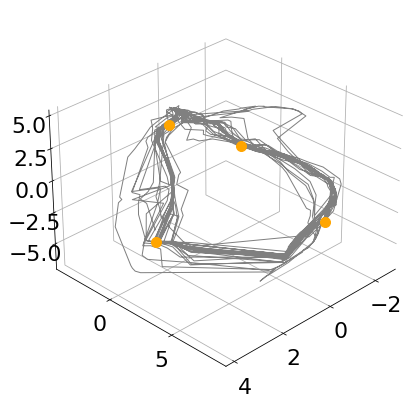

In [104]:
save_flag = True

PATH_TO_FIG = '../figures/'

if save_flag:
    if not os.path.exists(PATH_TO_FIG):
        os.makedirs(PATH_TO_FIG)

params = {
   'axes.labelsize': 26,
   'legend.fontsize': 24,
   'xtick.labelsize': 22,
   'ytick.labelsize': 22,
   'text.usetex': False,
   'figure.figsize': [7,7],
   'font.size': 24,
    'lines.markersize':10,
   }

plt.rcParams.update(params)

fig= plt.figure(figsize=[15,15])

ind_start = 80
# ind_time1 = 400
# ind_time2 = 438

ind_angle1 = 401
ind_angle2 = 412
ind_angle3 = 419
ind_angle4 = 427
# ind_angle1 = 400
# ind_angle2 = 412
# ind_angle3 = 420
# ind_angle4 = 430

ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax[0] = plt.axes(projection='3d')
ax.plot3D(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],c='gray',linewidth=1)
# ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])

ax.scatter(projected[ind_angle1,0],projected[ind_angle1,1],projected[ind_angle1,2],c='orange',s=100)
ax.scatter(projected[ind_angle2,0],projected[ind_angle2,1],projected[ind_angle2,2],c='orange',s=100)
ax.scatter(projected[ind_angle3,0],projected[ind_angle3,1],projected[ind_angle3,2],c='orange',s=100)
ax.scatter(projected[ind_angle4,0],projected[ind_angle4,1],projected[ind_angle4,2],c='orange',s=100)

# ax.set_xlabel('Proj 1')
# ax.set_zlabel('Proj 2')
# ax.set_ylabel('Proj 3')
# ax.set_title('Lateral view')
# ax.axis('off')
# right_side = ax.spines["right"]
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# right_side.set_visible(False)
ax.view_init(elev=30., azim=45)

# fig.tight_layout()

if save_flag:
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap.png', format='png', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap.pdf', format='pdf', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap.svg', format='svg', dpi=600, bbox_inches='tight')

### Frequency analysis

/tmp/ipykernel_2061736/3065611991.py:24: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[0].stem(freq[:n_oneside], np.abs(X[:n_oneside]), 'b', \
/tmp/ipykernel_2061736/3065611991.py:30: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[1].stem(freq1[:n_oneside], np.abs(X1[:n_oneside]), 'b', \
/tmp/ipykernel_2061736/3065611991.py:36: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[2].stem(freq2[:n_oneside], np.abs(X2[:n_oneside]), 'b', \


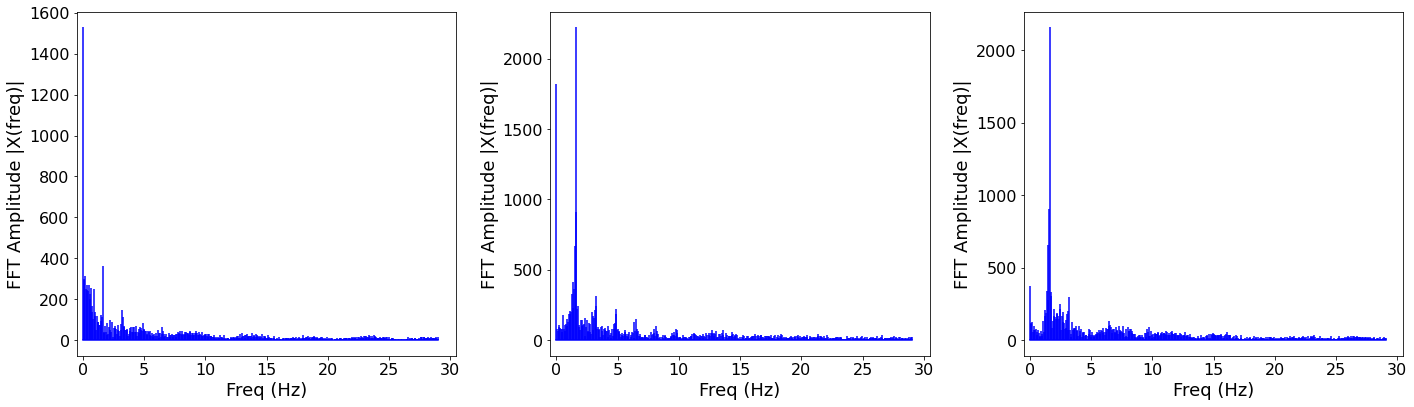

In [131]:
from numpy.fft import fft, ifft

ind_start = 0
delta_t = 0.0165 #Hz
sr = 1/delta_t
# t = np.arange(0,1000,delta_t)

def get_fft(data,sr):
    X = fft(data)
    N = len(X)
    n = np.arange(N)
    T = N/sr
    freq = n/T
    return freq, X

freq, X = get_fft(projected[ind_start:,0],sr)
freq1, X1 = get_fft(projected[ind_start:,1],sr)
freq2, X2 = get_fft(projected[ind_start:,2],sr)

n_oneside = N//2


fig,ax = plt.subplots(1,3,figsize = (20, 6))
ax[0].stem(freq[:n_oneside], np.abs(X[:n_oneside]), 'b', \
         markerfmt=" ", basefmt="-b")
ax[0].set_xlabel('Freq (Hz)')
ax[0].set_ylabel('FFT Amplitude |X(freq)|')
ax[0].set_xlim(-0.5, )

ax[1].stem(freq1[:n_oneside], np.abs(X1[:n_oneside]), 'b', \
         markerfmt=" ", basefmt="-b")
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('FFT Amplitude |X(freq)|')
ax[1].set_xlim(-0.5, )

ax[2].stem(freq2[:n_oneside], np.abs(X2[:n_oneside]), 'b', \
         markerfmt=" ", basefmt="-b")
ax[2].set_xlabel('Freq (Hz)')
ax[2].set_ylabel('FFT Amplitude |X(freq)|')
ax[2].set_xlim(-0.5, )

fig.tight_layout()
# plt.figure(figsize = (12, 6))
# plt.subplot(121)

# plt.stem(freq, np.abs(X), 'b', \
#          markerfmt=" ", basefmt="-b")
# plt.xlabel('Freq (Hz)')
# plt.ylabel('FFT Amplitude |X(freq)|')
# plt.xlim(0, 10)



# plt.subplot(122)
# plt.plot(t, ifft(X), 'r')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.tight_layout()
# plt.show()

In [132]:
f_max_ind = np.argmax(np.abs(X[1:n_oneside])) +1
print('Peak at freq: ', freq[f_max_ind])

f_max_ind = np.argmax(np.abs(X1[:n_oneside]))
print('Peak at freq: ', freq[f_max_ind])

f_max_ind = np.argmax(np.abs(X2[:n_oneside]))
print('Peak at freq: ', freq[f_max_ind])

Peak at freq:  1.6363636363636365
Peak at freq:  1.6363636363636365
Peak at freq:  1.6363636363636365


In [96]:
obs_all.shape

(100, 1000, 1, 28)

In [114]:
ind_angles = [ind for ind,state_name in enumerate(state_components) if '_angle' in state_name]

ind_start = 0

def get_fft(data,sr):
    X = fft(data)
    N = len(X)
    n = np.arange(N)
    T = N/sr
    freq = n/T
    return freq, X

fft_all = []
ind_component = []
for ii in range(len(ind_angles)):
    freq_tmp, X_tmp = get_fft(obs_all[0,ind_start:,0,ind_angles[ii]],sr)
    fft_all.append(X_tmp)
    ind_component.append(state_components[ind_angles[ii]])

In [115]:
ind_angles

[8, 10, 12, 14, 16, 18, 20, 22]

/tmp/ipykernel_2061736/322661980.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[ii].stem(freq[:n_oneside], np.abs(fft_all[ii][:n_oneside]), 'b', \
/tmp/ipykernel_2061736/322661980.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[ii].stem(freq[:n_oneside], np.abs(fft_all[ii][:n_oneside]), 'b', \
/tmp/ipykernel_2061736/322661980.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[ii].stem(freq[:n_oneside], np.abs(fft_all[ii][:n_oneside]), 'b', \
/tmp/ipykernel_2061736/322661980.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.

Peak for  hip_back_left_angle  at freq:  1.4545454545454546
Peak for  ankle_back_left_angle  at freq:  1.4545454545454546
Peak for  hip_front_left_angle  at freq:  1.4545454545454546
Peak for  ankle_front_left_angle  at freq:  1.4545454545454546
Peak for  hip_back_right_angle  at freq:  1.4545454545454546
Peak for  ankle_back_right_angle  at freq:  1.4545454545454546


/tmp/ipykernel_2061736/322661980.py:16: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[ii].stem(freq[:n_oneside], np.abs(fft_all[ii+4][:n_oneside]), 'b', \
/tmp/ipykernel_2061736/322661980.py:16: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[ii].stem(freq[:n_oneside], np.abs(fft_all[ii+4][:n_oneside]), 'b', \


Peak for  hip_front_right_angle  at freq:  1.4545454545454546
Peak for  ankle_front_right_angle  at freq:  1.4545454545454546


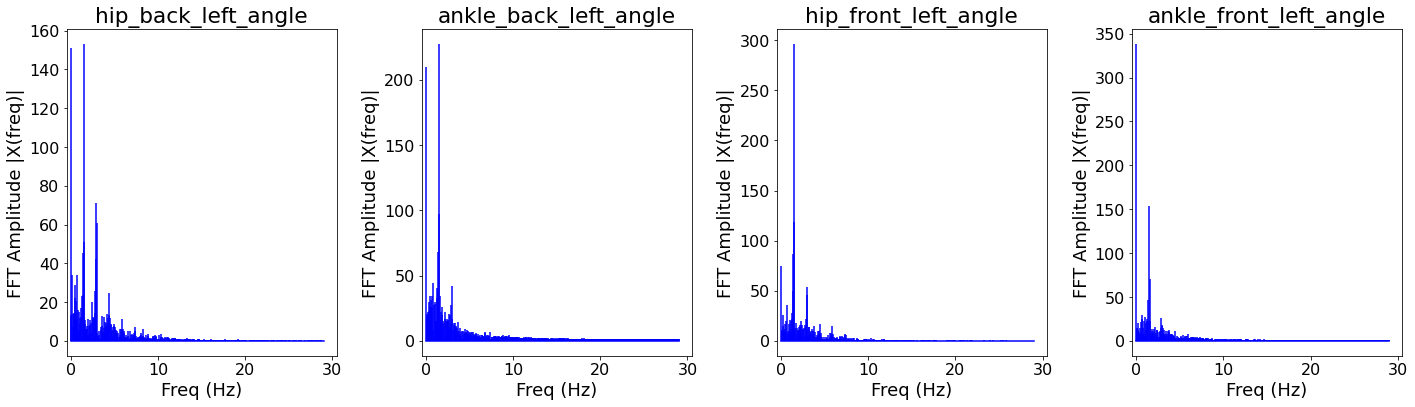

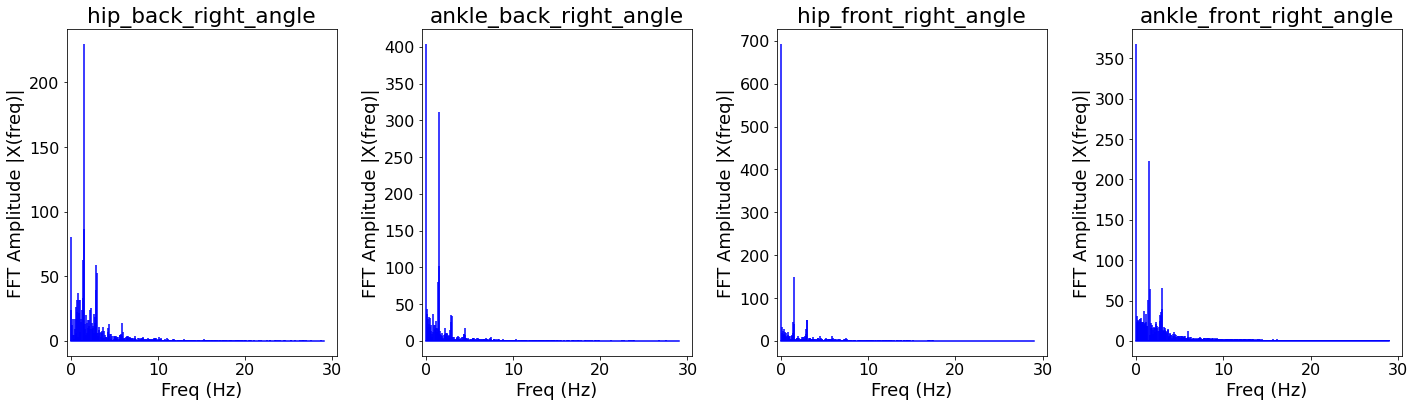

In [118]:
fig,ax = plt.subplots(1,4,figsize = (20, 6))
for ii in range(len(ind_angles)-4):
    ax[ii].stem(freq[:n_oneside], np.abs(fft_all[ii][:n_oneside]), 'b', \
            markerfmt=" ", basefmt="-b")
    ax[ii].set_xlabel('Freq (Hz)')
    ax[ii].set_ylabel('FFT Amplitude |X(freq)|')
    ax[ii].set_title(ind_component[ii])
    ax[ii].set_xlim(-0.5, )
    f_max_ind = np.argmax(np.abs(fft_all[ii][1:n_oneside])) + 1
    print('Peak for ', ind_component[ii],' at freq: ', freq[f_max_ind])

fig.tight_layout()

fig,ax = plt.subplots(1,4,figsize = (20, 6))
for ii in range(len(ind_angles)-4):
    ax[ii].stem(freq[:n_oneside], np.abs(fft_all[ii+4][:n_oneside]), 'b', \
            markerfmt=" ", basefmt="-b")
    ax[ii].set_xlabel('Freq (Hz)')
    ax[ii].set_ylabel('FFT Amplitude |X(freq)|')
    ax[ii].set_title(ind_component[ii+4])
    ax[ii].set_xlim(-0.5, )
    f_max_ind = np.argmax(np.abs(fft_all[ii+4][1:n_oneside])) + 1
    print('Peak for ', ind_component[ii+4],' at freq: ', freq[f_max_ind])

fig.tight_layout()

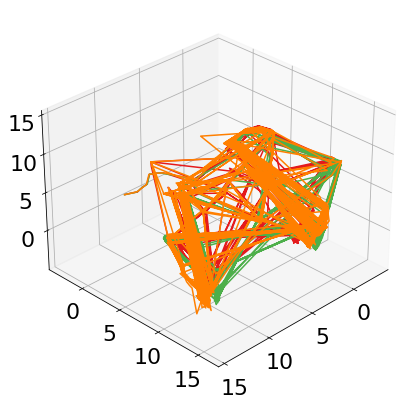

In [45]:
#### OBSERVATION SPACE

import umap

umap_red_obs = umap.UMAP(n_components=3,random_state=42)
# projected = pca.fit_transform(attention_episode.reshape(attention_episode.shape[0],-1))

### Fit on all time points
fitted_obs = umap_red_obs.fit(obs_all.reshape(-1,obs_all.shape[2]*obs_all.shape[3]))

n_projection = 3
ind_start = 0

cmap = mpl.colormaps['Set1']
colors = cmap(np.linspace(0,0.5,n_projection))
# colors = plt.cm.jet(np.linspace(0,1,n_projection))
projected_all_obs = []
for ii in range(n_projection):
    projected_obs = fitted_obs.transform(obs_all[ii,:,:,:].reshape(obs_all.shape[1],-1))
    projected_all_obs.append(projected_obs)

fig = plt.figure()
ax = plt.axes(projection='3d')

for ii in range(n_projection):
    projected_obs = projected_all_obs[ii]
    ax.plot(projected_obs[ind_start:,0],projected_obs[ind_start:,1],projected_obs[ind_start:,2],color = colors[ii])
ax.view_init(elev=30., azim=45)


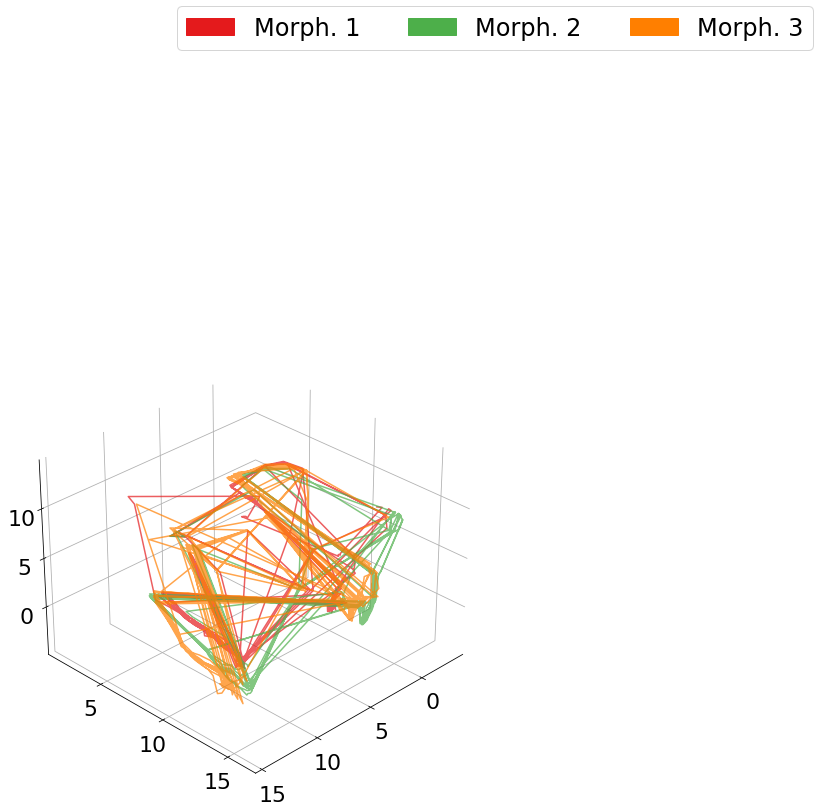

In [106]:
import matplotlib.patches as mpatches

save_flag = True

PATH_TO_FIG = '../figures/'

if save_flag:
    if not os.path.exists(PATH_TO_FIG):
        os.makedirs(PATH_TO_FIG)

params = {
   'axes.labelsize': 26,
   'legend.fontsize': 24,
   'xtick.labelsize': 22, #28,
   'ytick.labelsize': 22, #28,
   'text.usetex': False,
   'figure.figsize': [7,7],
   'font.size': 24,
    'lines.markersize':10,
   }

plt.rcParams.update(params)


ind_start = 80
ind_end = 500

fig = plt.figure(figsize=[14,14])
# ax = plt.axes(projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')

handles_list = []
for ii in range(n_projection):
    projected_obs = projected_all_obs[ii]
    ax.plot(projected_obs[ind_start:ind_end,0],projected_obs[ind_start:ind_end,1],projected_obs[ind_start:ind_end,2],color = colors[ii],alpha=0.7,label='Morph. '+str(ii))
    handles_list.append(mpatches.Patch(color=colors[ii], label='Morph. '+str(ii+1)))
ax.view_init(elev=30., azim=45)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='z', nbins=5)
# plt.legend()
# right_side.set_visible(False)
# ax.view_init(elev=00., azim=90)

fig.legend(handles=handles_list,frameon=True, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=24)
fig.tight_layout()


if save_flag:
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap_observation2.png', format='png', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap_observation2.pdf', format='pdf', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap_observation2.svg', format='svg', dpi=600, bbox_inches='tight')

/tmp/ipykernel_2061736/325997874.py:24: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[0].stem(freq[:n_oneside], np.abs(X[:n_oneside]), 'b', \
/tmp/ipykernel_2061736/325997874.py:30: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[1].stem(freq1[:n_oneside], np.abs(X1[:n_oneside]), 'b', \
/tmp/ipykernel_2061736/325997874.py:36: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[2].stem(freq2[:n_oneside], np.abs(X2[:n_oneside]), 'b', \


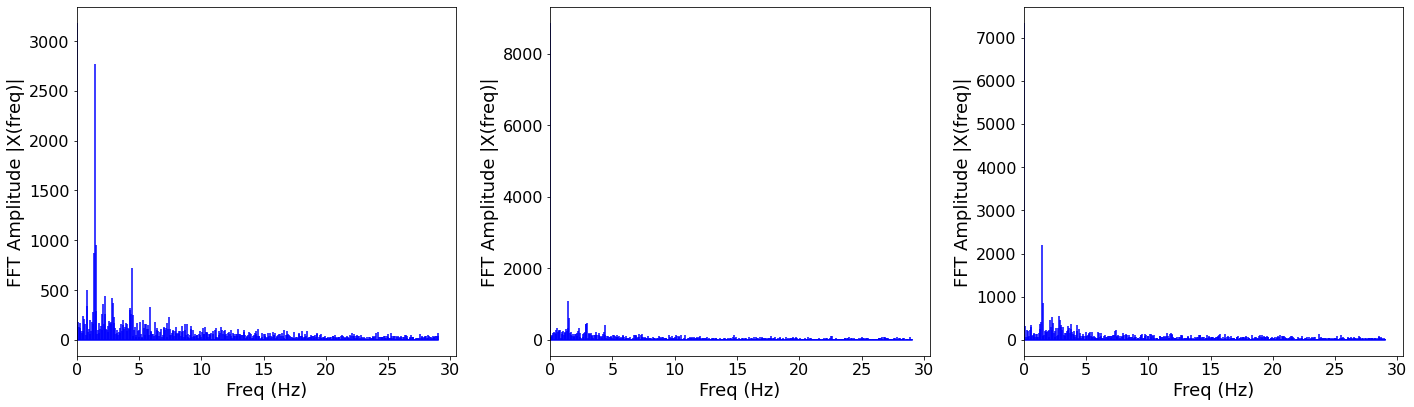

In [137]:
from numpy.fft import fft, ifft

ind_start = 0
delta_t = 0.0165 #Hz
sr = 1/delta_t
# t = np.arange(0,1000,delta_t)

def get_fft(data,sr):
    X = fft(data)
    N = len(X)
    n = np.arange(N)
    T = N/sr
    freq = n/T
    return freq, X

freq, X = get_fft(projected_all_obs[0][ind_start:,0],sr)
freq1, X1 = get_fft(projected_all_obs[0][ind_start:,1],sr)
freq2, X2 = get_fft(projected_all_obs[0][ind_start:,2],sr)

n_oneside = N//2


fig,ax = plt.subplots(1,3,figsize = (20, 6))
ax[0].stem(freq[:n_oneside], np.abs(X[:n_oneside]), 'b', \
         markerfmt=" ", basefmt="-b")
ax[0].set_xlabel('Freq (Hz)')
ax[0].set_ylabel('FFT Amplitude |X(freq)|')
ax[0].set_xlim(0, )

ax[1].stem(freq1[:n_oneside], np.abs(X1[:n_oneside]), 'b', \
         markerfmt=" ", basefmt="-b")
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('FFT Amplitude |X(freq)|')
ax[1].set_xlim(0, )

ax[2].stem(freq2[:n_oneside], np.abs(X2[:n_oneside]), 'b', \
         markerfmt=" ", basefmt="-b")
ax[2].set_xlabel('Freq (Hz)')
ax[2].set_ylabel('FFT Amplitude |X(freq)|')
ax[2].set_xlim(0, )

fig.tight_layout()

In [129]:
f_max_ind = np.argmax(np.abs(X[1:n_oneside])) +1
print('Peak at freq: ', freq[f_max_ind])

f_max_ind = np.argmax(np.abs(X1[1:n_oneside])) +1
print('Peak at freq: ', freq[f_max_ind])

f_max_ind = np.argmax(np.abs(X2[1:n_oneside])) +1
print('Peak at freq: ', freq[f_max_ind])

Peak at freq:  1.4545454545454546
Peak at freq:  1.4545454545454546
Peak at freq:  1.4545454545454546


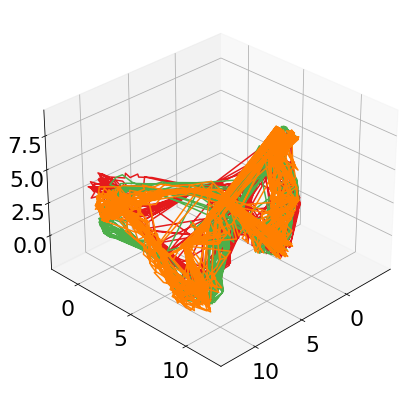

In [65]:
#### ACTION SPACE

import umap

umap_red_act = umap.UMAP(n_components=3)
# projected = pca.fit_transform(attention_episode.reshape(attention_episode.shape[0],-1))

### Fit on all time points
fitted_act = umap_red_act.fit(act_all.reshape(-1,act_all.shape[2]))

n_projection = 3
ind_start = 0

cmap = mpl.colormaps['Set1']
colors = cmap(np.linspace(0,0.5,n_projection))
# colors = plt.cm.jet(np.linspace(0,1,n_projection))
projected_all_act = []
for ii in range(n_projection):
    projected_act = fitted_act.transform(act_all[ii,:,:].reshape(act_all.shape[1],-1))
    projected_all_act.append(projected_act)

fig = plt.figure()
ax = plt.axes(projection='3d')

for ii in range(n_projection):
    projected_act = projected_all_act[ii]
    ax.plot(projected_act[ind_start:,0],projected_act[ind_start:,1],projected_act[ind_start:,2],color = colors[ii])
ax.view_init(elev=30., azim=45)

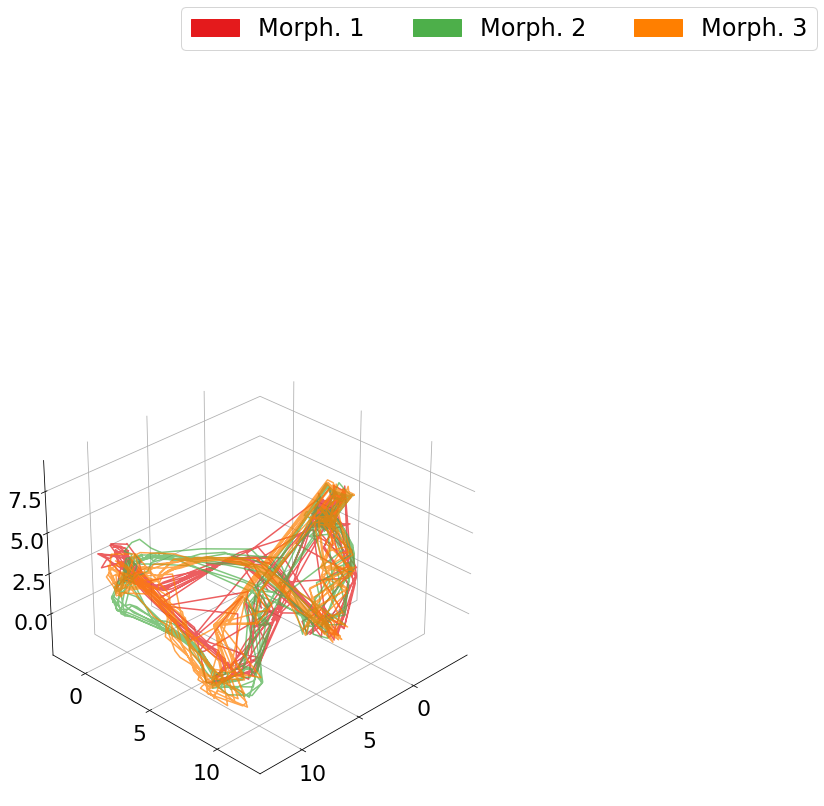

In [107]:
import matplotlib.patches as mpatches

save_flag = True

PATH_TO_FIG = '../figures/'

if save_flag:
    if not os.path.exists(PATH_TO_FIG):
        os.makedirs(PATH_TO_FIG)

params = {
   'axes.labelsize': 26,
   'legend.fontsize': 24,
   'xtick.labelsize': 22, #28,
   'ytick.labelsize': 22, #28,
   'text.usetex': False,
   'figure.figsize': [7,7],
   'font.size': 24,
    'lines.markersize':10,
   }

plt.rcParams.update(params)


ind_start = 80
ind_end = 500

fig = plt.figure(figsize=[14,14])
# ax = plt.axes(projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')

handles_list = []
for ii in range(n_projection):
    projected_act = projected_all_act[ii]
    ax.plot(projected_act[ind_start:ind_end,0],projected_act[ind_start:ind_end,1],projected_act[ind_start:ind_end,2],color = colors[ii],alpha=0.7,label='Morph. '+str(ii))
    handles_list.append(mpatches.Patch(color=colors[ii], label='Morph. '+str(ii+1)))
ax.view_init(elev=30., azim=45)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='z', nbins=5)
# plt.legend()
# right_side.set_visible(False)
# ax.view_init(elev=00., azim=90)

fig.legend(handles=handles_list,frameon=True, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=24)
fig.tight_layout()


if save_flag:
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap_action2.png', format='png', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap_action2.pdf', format='pdf', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_umap_action2.svg', format='svg', dpi=600, bbox_inches='tight')

/tmp/ipykernel_2061736/3748031344.py:24: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[0].stem(freq[:n_oneside], np.abs(X[:n_oneside]), 'b', \
/tmp/ipykernel_2061736/3748031344.py:30: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[1].stem(freq1[:n_oneside], np.abs(X1[:n_oneside]), 'b', \
/tmp/ipykernel_2061736/3748031344.py:36: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax[2].stem(freq2[:n_oneside], np.abs(X2[:n_oneside]), 'b', \


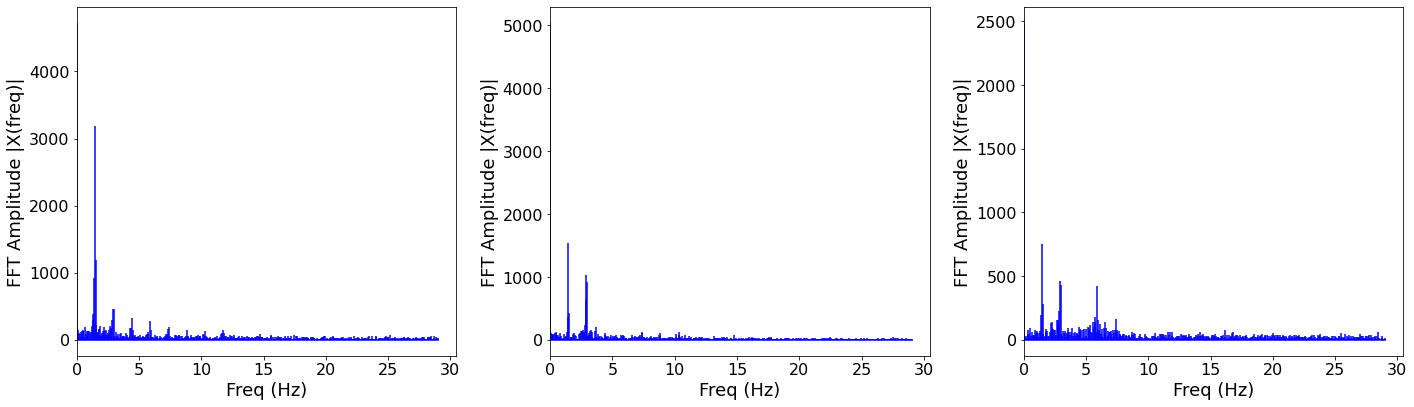

In [136]:
from numpy.fft import fft, ifft

ind_start = 0
delta_t = 0.0165 #Hz
sr = 1/delta_t
# t = np.arange(0,1000,delta_t)

def get_fft(data,sr):
    X = fft(data)
    N = len(X)
    n = np.arange(N)
    T = N/sr
    freq = n/T
    return freq, X

freq, X = get_fft(projected_all_act[0][ind_start:,0],sr)
freq1, X1 = get_fft(projected_all_act[0][ind_start:,1],sr)
freq2, X2 = get_fft(projected_all_act[0][ind_start:,2],sr)

n_oneside = N//2


fig,ax = plt.subplots(1,3,figsize = (20, 6))
ax[0].stem(freq[:n_oneside], np.abs(X[:n_oneside]), 'b', \
         markerfmt=" ", basefmt="-b")
ax[0].set_xlabel('Freq (Hz)')
ax[0].set_ylabel('FFT Amplitude |X(freq)|')
ax[0].set_xlim(0, )

ax[1].stem(freq1[:n_oneside], np.abs(X1[:n_oneside]), 'b', \
         markerfmt=" ", basefmt="-b")
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('FFT Amplitude |X(freq)|')
ax[1].set_xlim(0, )

ax[2].stem(freq2[:n_oneside], np.abs(X2[:n_oneside]), 'b', \
         markerfmt=" ", basefmt="-b")
ax[2].set_xlabel('Freq (Hz)')
ax[2].set_ylabel('FFT Amplitude |X(freq)|')
ax[2].set_xlim(0, )

fig.tight_layout()

In [135]:
f_max_ind = np.argmax(np.abs(X[1:n_oneside])) +1
print('Peak at freq: ', freq[f_max_ind])

f_max_ind = np.argmax(np.abs(X1[1:n_oneside])) +1
print('Peak at freq: ', freq[f_max_ind])

f_max_ind = np.argmax(np.abs(X2[1:n_oneside])) +1
print('Peak at freq: ', freq[f_max_ind])

Peak at freq:  1.4545454545454546
Peak at freq:  1.4545454545454546
Peak at freq:  1.4545454545454546


#### look at each projection?

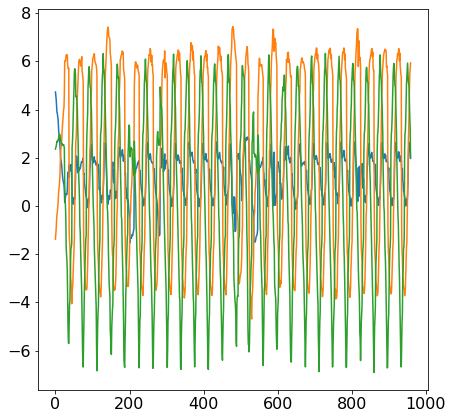

In [83]:
plt.figure()
plt.plot(np.arange(projected[ind_start:,0].shape[0]),projected[ind_start:,0])
plt.plot(np.arange(projected[ind_start:,0].shape[0]),projected[ind_start:,1])
plt.plot(np.arange(projected[ind_start:,0].shape[0]),projected[ind_start:,2])

In [27]:
from scipy import optimize

def sin_func(x, a, b, c):
    return a * np.sin(b * x) + c

params_proj0, params_covariance_proj0 = optimize.curve_fit(sin_func, np.arange(projected[ind_start:,0].shape[0]), projected[ind_start:,0],
                                               p0=[2, 2, 2])

params_proj1, params_covariance_proj1 = optimize.curve_fit(sin_func, np.arange(projected[ind_start:,0].shape[0]), projected[ind_start:,1],
                                               p0=[2, 2, 2])

params_proj2, params_covariance_proj2 = optimize.curve_fit(sin_func, np.arange(projected[ind_start:,0].shape[0]), projected[ind_start:,2],
                                               p0=[2, 2, 2])

In [58]:
from scipy.optimize import leastsq

def sin_fun(x,a,b,c,d):
    return a*np.sin(b*x+c) + d

def fit_sin(data):
    guess_mean = np.mean(data)
    guess_std = 3*np.std(data)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = 1
    guess_amp = 2

    N = data.shape[0] # number of data points
    t = np.linspace(0, 4*np.pi, N)

    # print(data.shape[0])

    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data

    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
    return (est_amp, est_freq, est_phase, est_mean)

params_proj0 = fit_sin(projected[ind_start:,0])

In [59]:
print(params_proj0[0], params_proj0[1], params_proj0[2], params_proj0[3])

-0.1969397409672241 1.2406408638355022 -1.474094307153109 1.2722865132476944


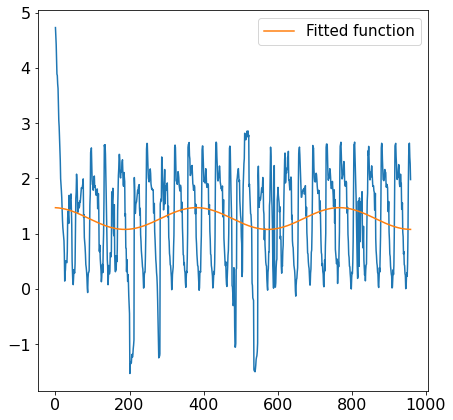

In [60]:
N = projected[ind_start:,0].shape[0] # number of data points
t = np.linspace(0, 4*np.pi, N)

plt.figure()
plt.plot(np.arange(projected[ind_start:,0].shape[0]),projected[ind_start:,0])
plt.plot(np.arange(projected[ind_start:,0].shape[0]), sin_fun(t, params_proj0[0], params_proj0[1], params_proj0[2], params_proj0[3]),
         label='Fitted function')
plt.legend()

### Inheritance analysis

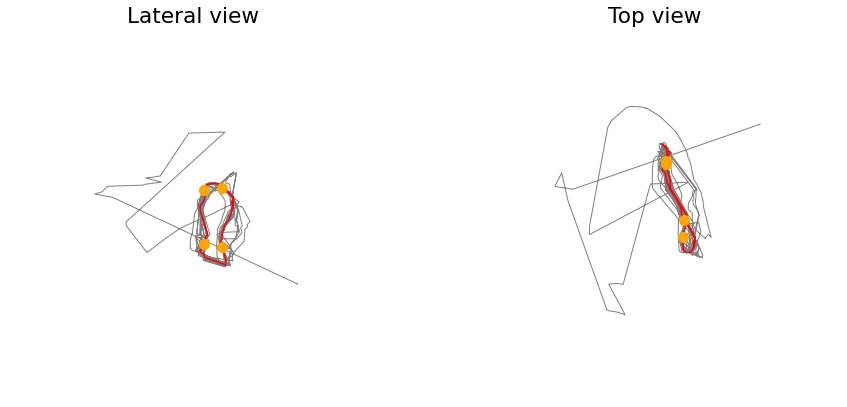

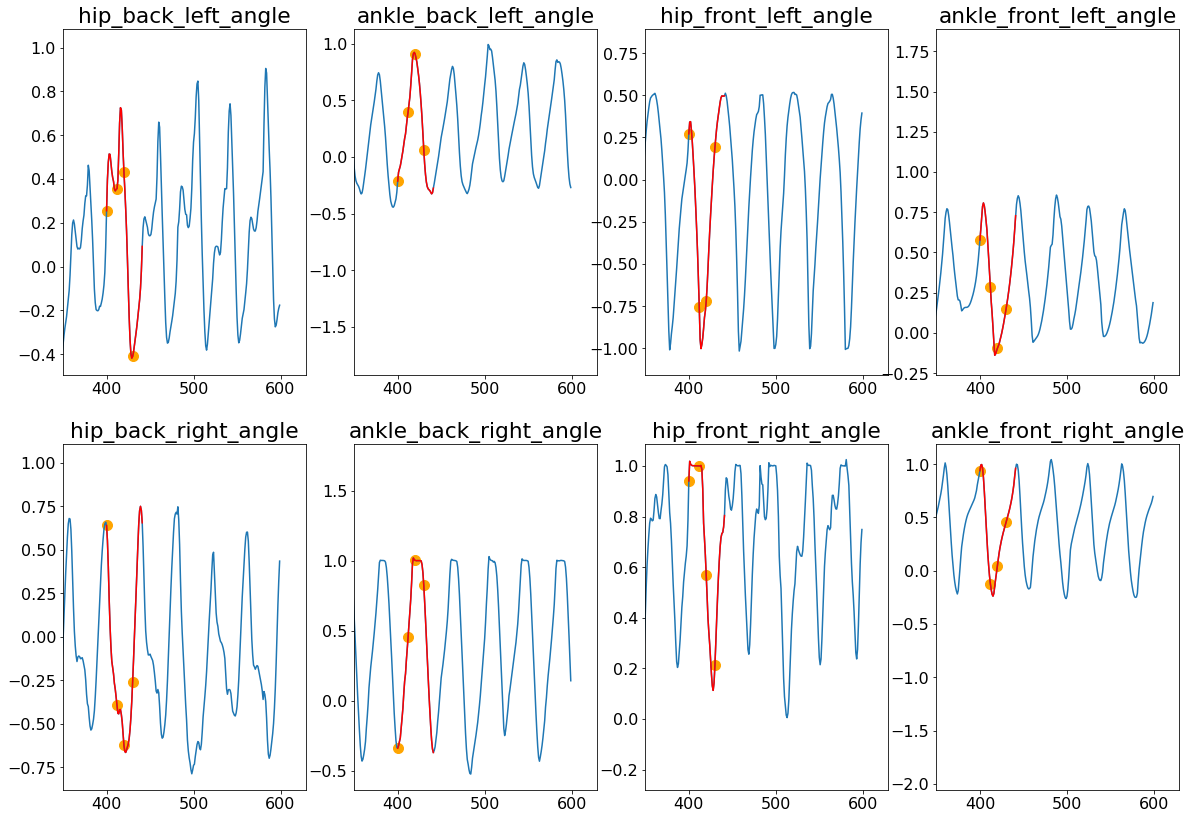

In [26]:
### Look at the dynamic wrt to observation
ind_angles = [ind for ind,state_name in enumerate(state_components) if '_angle' in state_name]


ind_start = 0
ind_xml = 0
ind_time1 = 400
ind_time2 = 442

ind_angle1 = 400
ind_angle2 = 412
ind_angle3 = 420
ind_angle4 = 430

fig= plt.figure(figsize=[14,6])

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],c='gray',linewidth=1)
ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.scatter(projected[ind_angle1,0],projected[ind_angle1,1],projected[ind_angle1,2],c='orange',s=100)
ax.scatter(projected[ind_angle2,0],projected[ind_angle2,1],projected[ind_angle2,2],c='orange',s=100)
ax.scatter(projected[ind_angle3,0],projected[ind_angle3,1],projected[ind_angle3,2],c='orange',s=100)
ax.scatter(projected[ind_angle4,0],projected[ind_angle4,1],projected[ind_angle4,2],c='orange',s=100)

ax.set_xlabel('X')
ax.set_zlabel('Z')
ax.set_ylabel('Y')
ax.set_title('Lateral view')
ax.axis('off')
ax.view_init(elev=0., azim=90)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot3D(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],c='gray',linewidth=1)
ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.scatter(projected[ind_angle1,0],projected[ind_angle1,1],projected[ind_angle1,2],c='orange',s=100)
ax.scatter(projected[ind_angle2,0],projected[ind_angle2,1],projected[ind_angle2,2],c='orange',s=100)
ax.scatter(projected[ind_angle3,0],projected[ind_angle3,1],projected[ind_angle3,2],c='orange',s=100)
ax.scatter(projected[ind_angle4,0],projected[ind_angle4,1],projected[ind_angle4,2],c='orange',s=100)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Top view')
ax.axis('off')
ax.view_init(elev=90., azim=90)

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()



fig,ax = plt.subplots(2,4,figsize=[20,14])

joint_angle_ind1 = []
joint_angle_ind2 = []
joint_angle_ind3 = []
joint_angle_ind4 = []
joint_list_name = []

dict_joint = {
    'env': 'ant',
    'train_sigma': sigma,
    'test_sigma': test_sigma,
    'xml': ind_xml
}

cc = 0
for ii in range(2):
    for jj in range(4):
        ax[ii,jj].plot(obs_all[ind_xml,:600,0,ind_angles[cc]])
        ax[ii,jj].plot(np.arange(ind_time1,ind_time2),obs_all[ind_xml,ind_time1:ind_time2,0,ind_angles[cc]],c='r')

        ax[ii,jj].scatter(ind_angle1,obs_all[ind_xml,ind_angle1,0,ind_angles[cc]],c='orange',s=100)
        ax[ii,jj].scatter(ind_angle2,obs_all[ind_xml,ind_angle2,0,ind_angles[cc]],c='orange',s=100)
        ax[ii,jj].scatter(ind_angle3,obs_all[ind_xml,ind_angle3,0,ind_angles[cc]],c='orange',s=100)
        ax[ii,jj].scatter(ind_angle4,obs_all[ind_xml,ind_angle4,0,ind_angles[cc]],c='orange',s=100)

        ax[ii,jj].set_title(state_components[ind_angles[cc]])
        ax[ii,jj].set_xlim(350,)

        joint_angle_ind1.append(obs_all[ind_xml,ind_angle1,0,ind_angles[cc]])
        joint_angle_ind2.append(obs_all[ind_xml,ind_angle2,0,ind_angles[cc]])
        joint_angle_ind3.append(obs_all[ind_xml,ind_angle3,0,ind_angles[cc]])
        joint_angle_ind4.append(obs_all[ind_xml,ind_angle4,0,ind_angles[cc]])
        joint_list_name.append(state_components[ind_angles[cc]])

        cc += 1

dict_joint['time1'] =joint_angle_ind1
dict_joint['time2'] =joint_angle_ind2
dict_joint['time3'] =joint_angle_ind3
dict_joint['time4'] =joint_angle_ind4
dict_joint['joint_list_name'] =joint_list_name

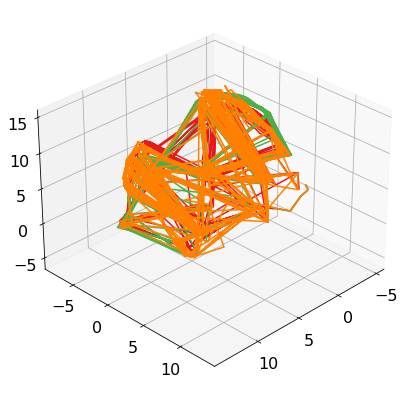

In [15]:
#### OBSERVATION SPACE

import umap

umap_red_obs = umap.UMAP(n_components=3)
# projected = pca.fit_transform(attention_episode.reshape(attention_episode.shape[0],-1))

### Fit on all time points
fitted_obs = umap_red_obs.fit(obs_all.reshape(-1,obs_all.shape[2]*obs_all.shape[3]))

n_projection = 3
ind_start = 0

cmap = mpl.colormaps['Set1']
colors = cmap(np.linspace(0,0.5,n_projection))
# colors = plt.cm.jet(np.linspace(0,1,n_projection))
projected_all_obs = []
for ii in range(n_projection):
    projected_obs = fitted_obs.transform(obs_all[ii,:,:,:].reshape(obs_all.shape[1],-1))
    projected_all_obs.append(projected_obs)

fig = plt.figure()
ax = plt.axes(projection='3d')

for ii in range(n_projection):
    projected_obs = projected_all_obs[ii]
    ax.plot(projected_obs[ind_start:,0],projected_obs[ind_start:,1],projected_obs[ind_start:,2],color = colors[ii])
ax.view_init(elev=30., azim=45)


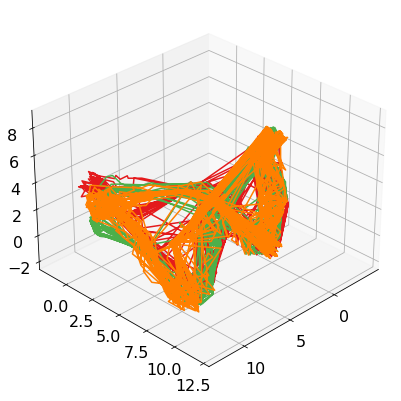

In [16]:
#### ACTION SPACE

import umap

umap_red_act = umap.UMAP(n_components=3)
# projected = pca.fit_transform(attention_episode.reshape(attention_episode.shape[0],-1))

### Fit on all time points
fitted_act = umap_red_act.fit(act_all.reshape(-1,act_all.shape[2]))

n_projection = 3
ind_start = 0

cmap = mpl.colormaps['Set1']
colors = cmap(np.linspace(0,0.5,n_projection))
# colors = plt.cm.jet(np.linspace(0,1,n_projection))
projected_all_act = []
for ii in range(n_projection):
    projected_act = fitted_act.transform(act_all[ii,:,:].reshape(act_all.shape[1],-1))
    projected_all_act.append(projected_act)

fig = plt.figure()
ax = plt.axes(projection='3d')

for ii in range(n_projection):
    projected_act = projected_all_act[ii]
    ax.plot(projected_act[ind_start:,0],projected_act[ind_start:,1],projected_act[ind_start:,2],color = colors[ii])
ax.view_init(elev=30., azim=45)

In [23]:
act_all.shape

(100, 1000, 8)

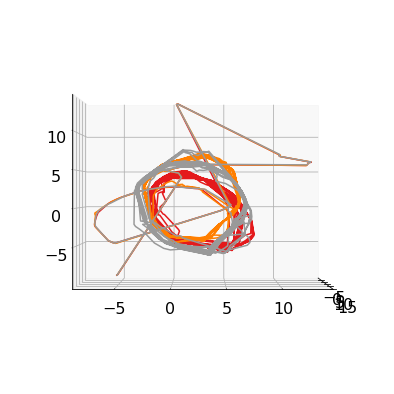

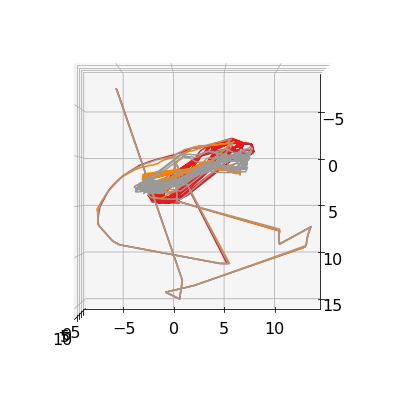

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for ii in range(n_projection):
    projected = projected_all[ii]
    ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],color = colors[ii])
ax.view_init(elev=0., azim=0)

fig = plt.figure()
ax = plt.axes(projection='3d')

for ii in range(n_projection):
    projected = projected_all[ii]
    ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],color = colors[ii])
ax.view_init(elev=90., azim=0)

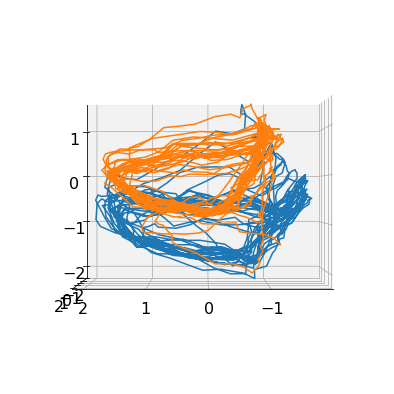

In [104]:
ind_start = 40
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2])
ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])
# ax.plot(projected2[ind_start:,0],projected2[ind_start:,1],projected2[ind_start:,2])
# ax.plot(projected3[ind_start:,0],projected3[ind_start:,1],projected3[ind_start:,2])
# ax.plot(projected4[ind_start:,0],projected4[ind_start:,1],projected4[ind_start:,2])
ax.view_init(elev=0., azim=90)

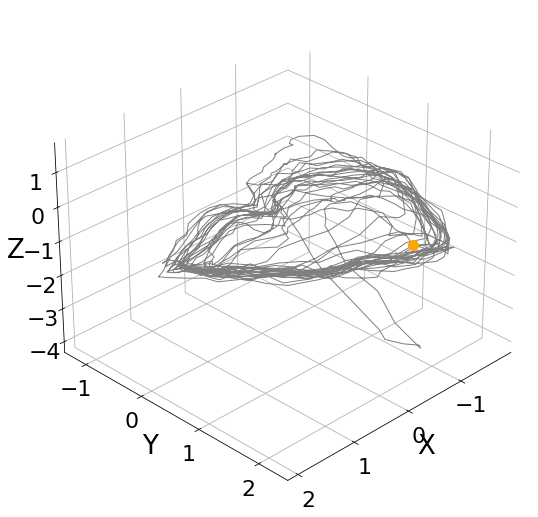

In [198]:
save_flag = False

PATH_TO_FIG = '../figures/'

if save_flag:
    if not os.path.exists(PATH_TO_FIG):
        os.makedirs(PATH_TO_FIG)

params = {
   'axes.labelsize': 26,
   'legend.fontsize': 24,
   'xtick.labelsize': 22,
   'ytick.labelsize': 22,
   'text.usetex': False,
   'figure.figsize': [7,7],
   'font.size': 24,
    'lines.markersize':10,
   }

plt.rcParams.update(params)

fig= plt.figure(figsize=[15,15])

ind_angle1 = 400
ind_angle2 = 412
ind_angle3 = 420
ind_angle4 = 430

ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax[0] = plt.axes(projection='3d')
ax.plot3D(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],c='gray',linewidth=1)
# ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])

# ax.scatter(projected[ind_angle1,0],projected[ind_angle1,1],projected[ind_angle1,2],c='orange',s=100)
# ax.scatter(projected[ind_angle2,0],projected[ind_angle2,1],projected[ind_angle2,2],c='orange',s=100)
ax.scatter(projected[ind_angle3,0],projected[ind_angle3,1],projected[ind_angle3,2],c='orange',s=100)
# ax.scatter(projected[ind_angle4,0],projected[ind_angle4,1],projected[ind_angle4,2],c='orange',s=100)

ax.set_xlabel('X')
ax.set_zlabel('Z')
ax.set_ylabel('Y')
# ax.set_title('Lateral view')
# ax.axis('off')
# right_side = ax.spines["right"]
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# right_side.set_visible(False)
ax.view_init(elev=30., azim=45)

fig.tight_layout()

if save_flag:
    plt.savefig(PATH_TO_FIG + 'ant_attention_vamp.png', format='png', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_vamp.pdf', format='pdf', dpi=600, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ant_attention_vamp.svg', format='svg', dpi=600, bbox_inches='tight')

In [172]:
sigma

'sigma_01'

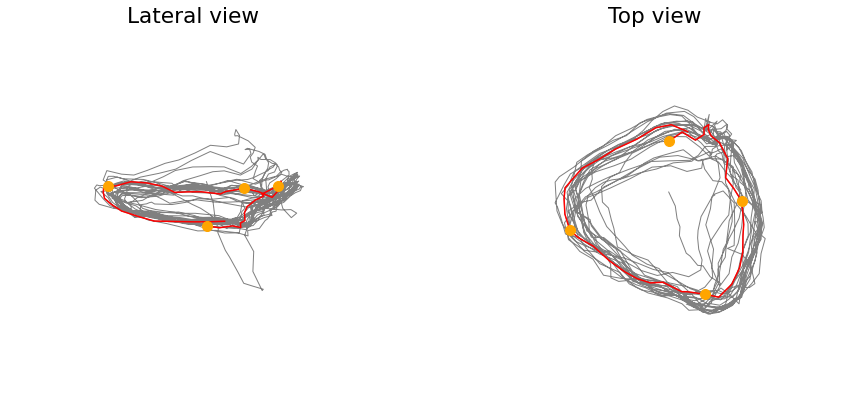

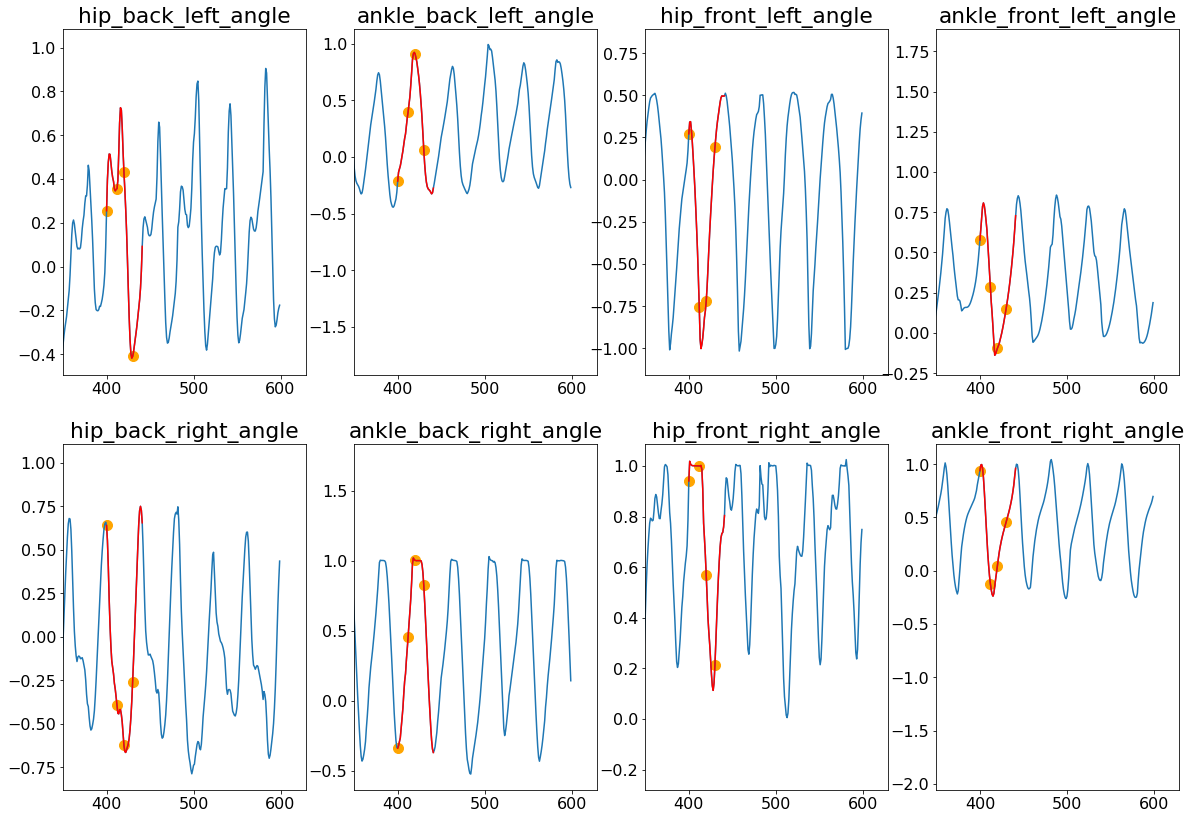

In [173]:
### Look at the dynamic wrt to observation
ind_angles = [ind for ind,state_name in enumerate(state_components) if '_angle' in state_name]


ind_start = 0
ind_xml = 0
ind_time1 = 400
ind_time2 = 442

ind_angle1 = 400
ind_angle2 = 412
ind_angle3 = 420
ind_angle4 = 430

fig= plt.figure(figsize=[14,6])

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],c='gray',linewidth=1)
ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.scatter(projected[ind_angle1,0],projected[ind_angle1,1],projected[ind_angle1,2],c='orange',s=100)
ax.scatter(projected[ind_angle2,0],projected[ind_angle2,1],projected[ind_angle2,2],c='orange',s=100)
ax.scatter(projected[ind_angle3,0],projected[ind_angle3,1],projected[ind_angle3,2],c='orange',s=100)
ax.scatter(projected[ind_angle4,0],projected[ind_angle4,1],projected[ind_angle4,2],c='orange',s=100)

ax.set_xlabel('X')
ax.set_zlabel('Z')
ax.set_ylabel('Y')
ax.set_title('Lateral view')
ax.axis('off')
ax.view_init(elev=0., azim=90)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot3D(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2],c='gray',linewidth=1)
ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.scatter(projected[ind_angle1,0],projected[ind_angle1,1],projected[ind_angle1,2],c='orange',s=100)
ax.scatter(projected[ind_angle2,0],projected[ind_angle2,1],projected[ind_angle2,2],c='orange',s=100)
ax.scatter(projected[ind_angle3,0],projected[ind_angle3,1],projected[ind_angle3,2],c='orange',s=100)
ax.scatter(projected[ind_angle4,0],projected[ind_angle4,1],projected[ind_angle4,2],c='orange',s=100)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Top view')
ax.axis('off')
ax.view_init(elev=90., azim=90)

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()



fig,ax = plt.subplots(2,4,figsize=[20,14])

joint_angle_ind1 = []
joint_angle_ind2 = []
joint_angle_ind3 = []
joint_angle_ind4 = []
joint_list_name = []

dict_joint = {
    'env': 'ant',
    'train_sigma': sigma,
    'test_sigma': test_sigma,
    'xml': ind_xml
}

cc = 0
for ii in range(2):
    for jj in range(4):
        ax[ii,jj].plot(obs_all[ind_xml,:600,0,ind_angles[cc]])
        ax[ii,jj].plot(np.arange(ind_time1,ind_time2),obs_all[ind_xml,ind_time1:ind_time2,0,ind_angles[cc]],c='r')

        ax[ii,jj].scatter(ind_angle1,obs_all[ind_xml,ind_angle1,0,ind_angles[cc]],c='orange',s=100)
        ax[ii,jj].scatter(ind_angle2,obs_all[ind_xml,ind_angle2,0,ind_angles[cc]],c='orange',s=100)
        ax[ii,jj].scatter(ind_angle3,obs_all[ind_xml,ind_angle3,0,ind_angles[cc]],c='orange',s=100)
        ax[ii,jj].scatter(ind_angle4,obs_all[ind_xml,ind_angle4,0,ind_angles[cc]],c='orange',s=100)

        ax[ii,jj].set_title(state_components[ind_angles[cc]])
        ax[ii,jj].set_xlim(350,)

        joint_angle_ind1.append(obs_all[ind_xml,ind_angle1,0,ind_angles[cc]])
        joint_angle_ind2.append(obs_all[ind_xml,ind_angle2,0,ind_angles[cc]])
        joint_angle_ind3.append(obs_all[ind_xml,ind_angle3,0,ind_angles[cc]])
        joint_angle_ind4.append(obs_all[ind_xml,ind_angle4,0,ind_angles[cc]])
        joint_list_name.append(state_components[ind_angles[cc]])

        cc += 1

dict_joint['time1'] =joint_angle_ind1
dict_joint['time2'] =joint_angle_ind2
dict_joint['time3'] =joint_angle_ind3
dict_joint['time4'] =joint_angle_ind4
dict_joint['joint_list_name'] =joint_list_name

In [174]:
save_dict = False
if save_dict:
    with open('ant_joints.json', 'w') as fp:
        json.dump(dict_joint, fp)

### Animation attempt

In [28]:
projected = projected.T

<IPython.core.display.Javascript object>


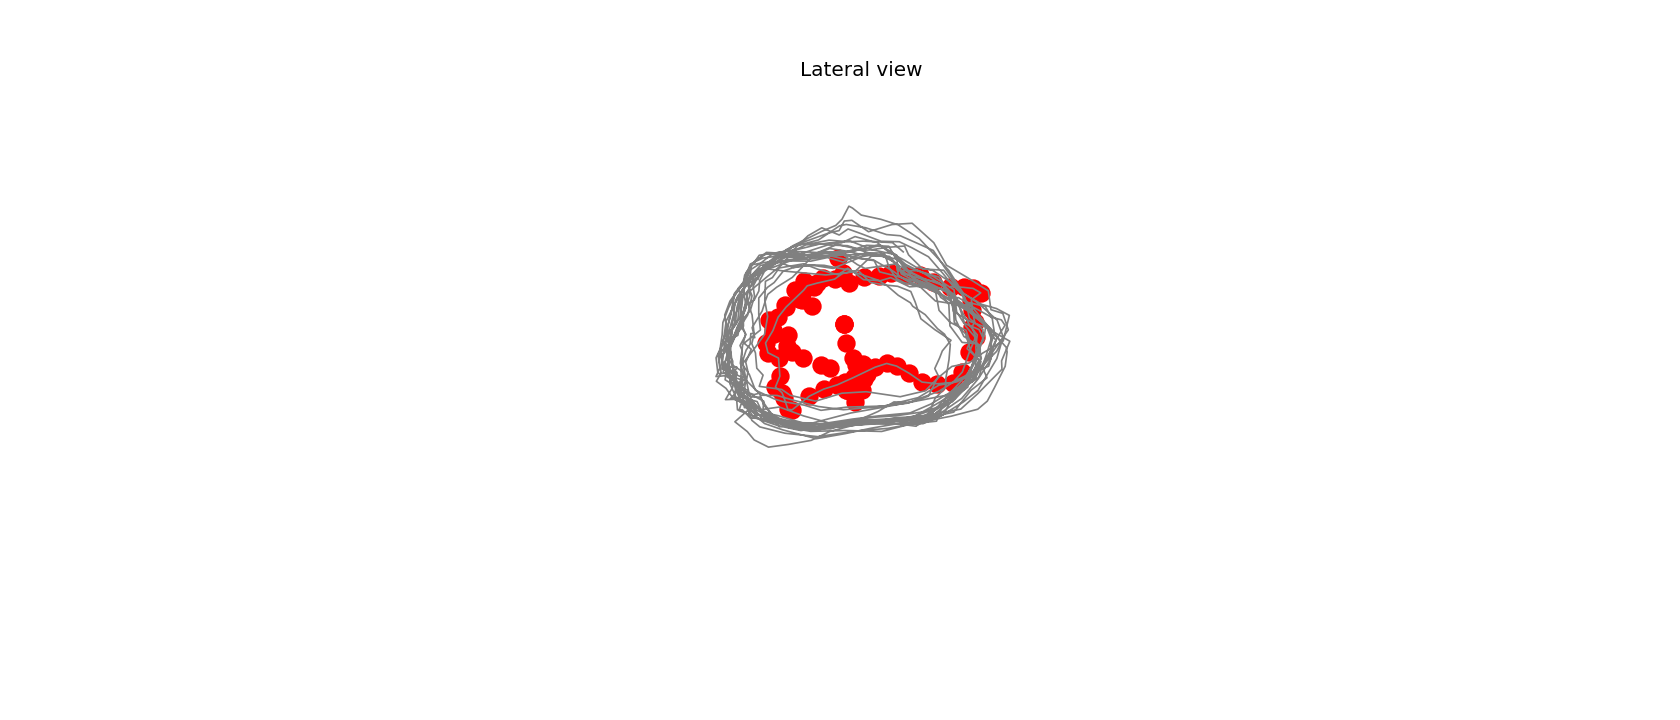

In [48]:
from matplotlib import animation

def update_point(n, projected, point):
#     point.set_data(np.array([projected[n,0], projected[n,1]]))
    point.set_data(projected[0:2,:n])    
#     line.set_3d_properties(dataSet[2, :num])  
    point.set_3d_properties(projected[2,:n], 'z')
    print(projected[2,:n])
    return point

fig= plt.figure(figsize=[14,6])

ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax[0] = plt.axes(projection='3d')
point, = ax.plot(projected[0], projected[1], projected[2], 'o', lw=0.5, c='r')
line, = ax.plot3D(projected[0,ind_start:],projected[1,ind_start:],projected[2,ind_start:],c='gray',linewidth=1)
# ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])
ax.set_xlabel('X')
ax.set_zlabel('Z')
ax.set_ylabel('Y')
ax.set_title('Lateral view')
ax.axis('off')
# right_side = ax.spines["right"]
# ax.view_init(elev=0., azim=90)

ani=animation.FuncAnimation(fig, update_point, 99, fargs=(projected, point))

plt.show()

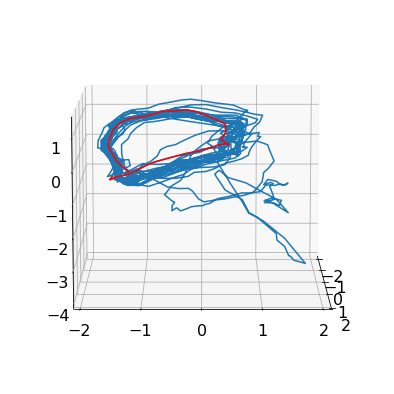

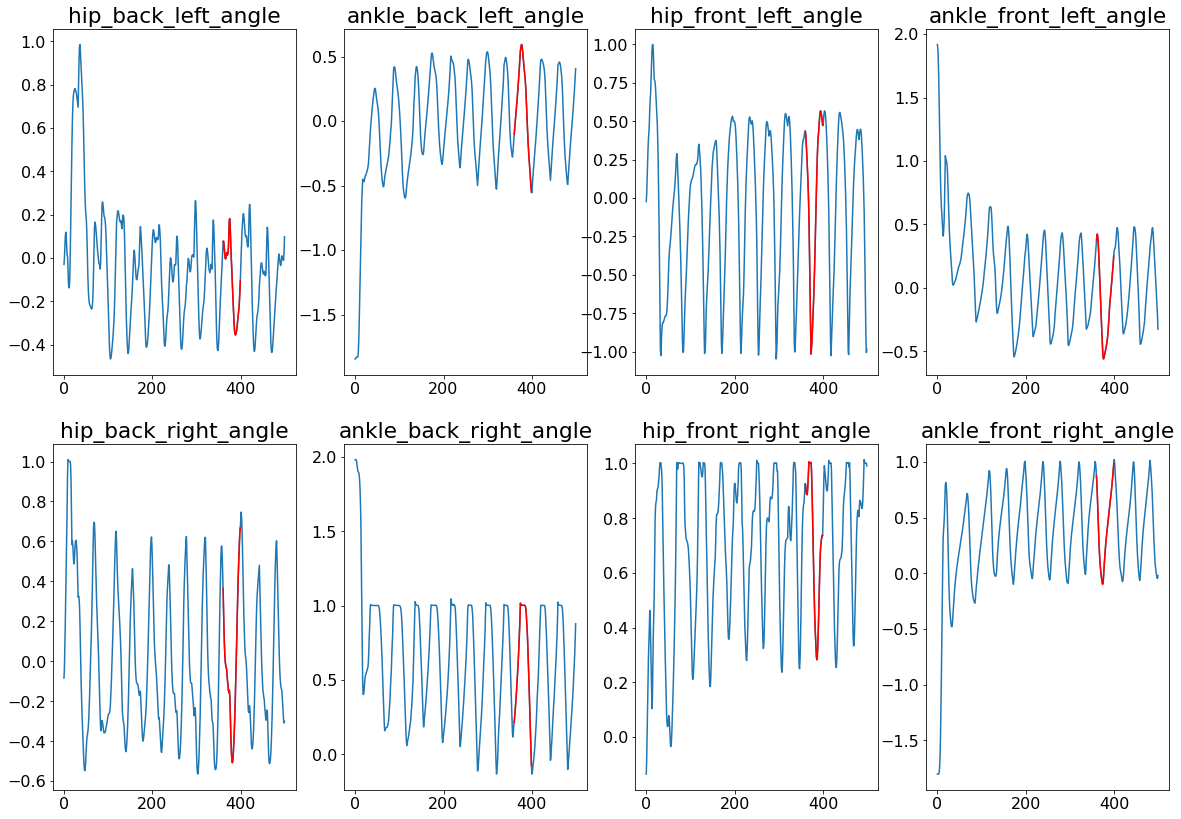

In [88]:
### Look at the dynamic wrt to observation
ind_angles = [ind for ind,state_name in enumerate(state_components) if '_angle' in state_name]

from mpl_toolkits import mplot3d
ind_start = 0
ind_xml = 1
ind_time1 = 360
ind_time2 = 400
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2])

# ax.scatter(projected[ind_time,0],projected[ind_time,1],projected[ind_time,2],c='r',s=100)
# ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])
ax.plot(projected1[ind_time1:ind_time2,0],projected1[ind_time1:ind_time2,1],projected1[ind_time1:ind_time2,2],c='r')

# ax.plot(projected2[ind_start:,0],projected2[ind_start:,1],projected2[ind_start:,2])
# ax.plot(projected3[ind_start:,0],projected3[ind_start:,1],projected3[ind_start:,2])
ax.view_init(elev=10., azim=0)

fig,ax = plt.subplots(2,4,figsize=[20,14])

cc = 0
for ii in range(2):
    for jj in range(4):
        ax[ii,jj].plot(obs_all[ind_xml,:500,0,ind_angles[cc]])
        ax[ii,jj].plot(np.arange(ind_time1,ind_time2),obs_all[ind_xml,ind_time1:ind_time2,0,ind_angles[cc]],c='r')
        ax[ii,jj].set_title(state_components[ind_angles[cc]])
        cc += 1

In [86]:
### LINEAR REGRESSION FROM VAMP


projected = fitted.transform(attention_episode_all_stack.reshape(attention_episode_all_stack.shape[1]*100,-1))

projected = projected.reshape(100,1000,3)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(projected.mean(axis=1), perturbation_all.mean(axis=1), test_size=0.3, random_state=42)

reg = Ridge(alpha=0.10).fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

print('R2 train: ', r2_score(y_train, y_pred_train))
print('R2 test: ', r2_score(y_test, y_pred_test))

fig,ax = plt.subplots()
for ii in range(y_test.shape[1]):
    plt.scatter(y_test[:,ii],y_pred_test[:,ii],s=2)
plt.axline((1, 1), slope=1, ls='--', color='dimgray', alpha=1.0, label='')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)
# ax.set_xlim(-0.5,0.6)
# ax.set_ylim(-0.5,0.6)

R2 train:  0.31657071142827065
R2 test:  0.14629780995548808


In [56]:
perturbation_all.shape

(100, 1000, 9)

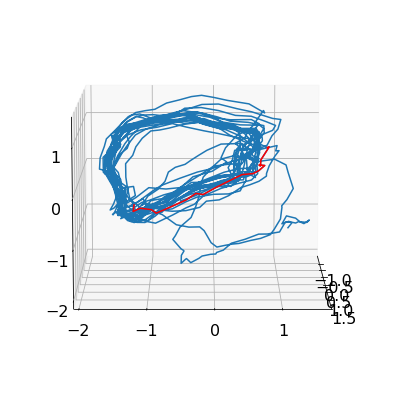

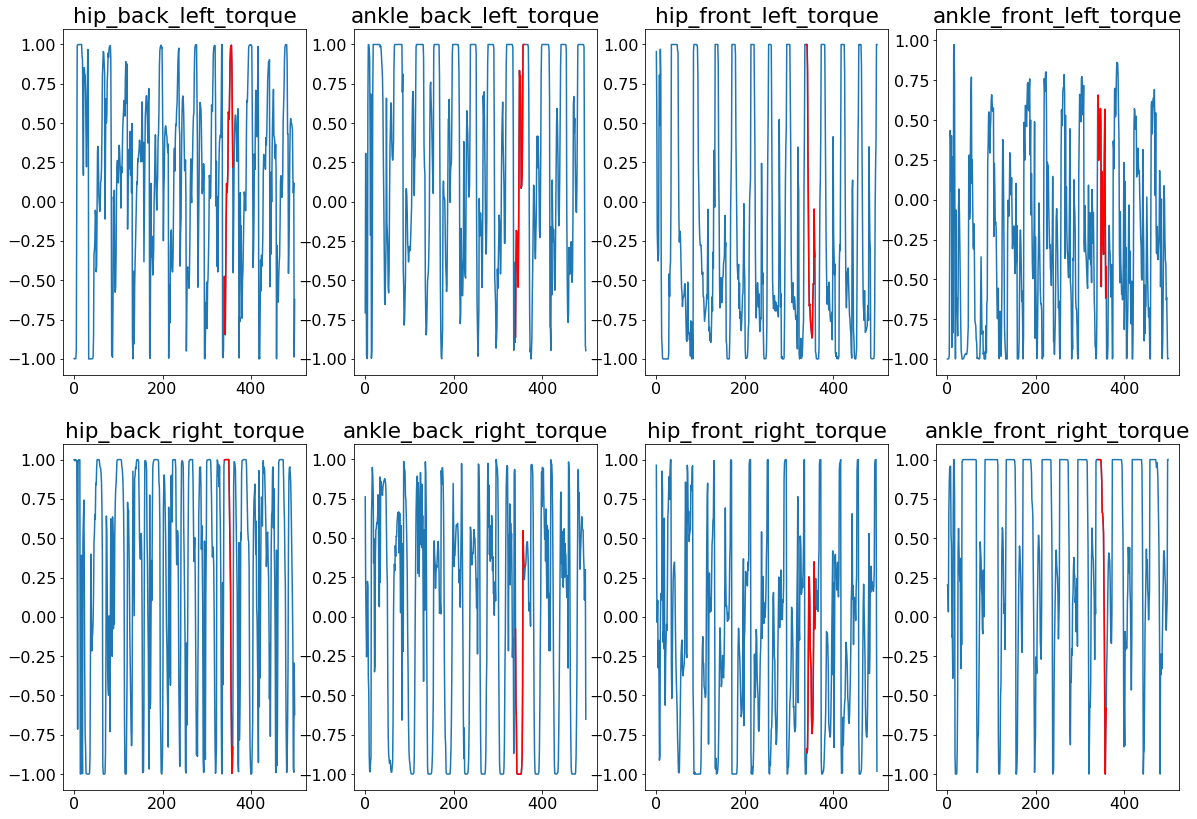

In [13]:
from mpl_toolkits import mplot3d
ind_start = 40
ind_xml = 1
ind_time1 = 340
ind_time2 = 360
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2])

# ax.scatter(projected[ind_time,0],projected[ind_time,1],projected[ind_time,2],c='r',s=100)
# ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])
ax.plot(projected1[ind_time1:ind_time2,0],projected1[ind_time1:ind_time2,1],projected1[ind_time1:ind_time2,2],c='r')

# ax.plot(projected2[ind_start:,0],projected2[ind_start:,1],projected2[ind_start:,2])
# ax.plot(projected3[ind_start:,0],projected3[ind_start:,1],projected3[ind_start:,2])
ax.view_init(elev=10., azim=0)

fig,ax = plt.subplots(2,4,figsize=[20,14])

cc = 0
for ii in range(2):
    for jj in range(4):
        ax[ii,jj].plot(act_all[ind_xml,:500,cc])
        ax[ii,jj].plot(np.arange(ind_time1,ind_time2),act_all[ind_xml,ind_time1:ind_time2,cc],c='r')
        ax[ii,jj].set_title(action_components[cc])
        cc += 1

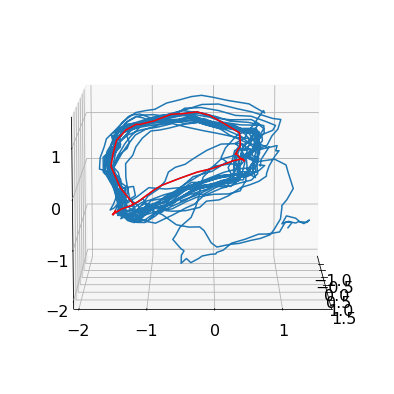

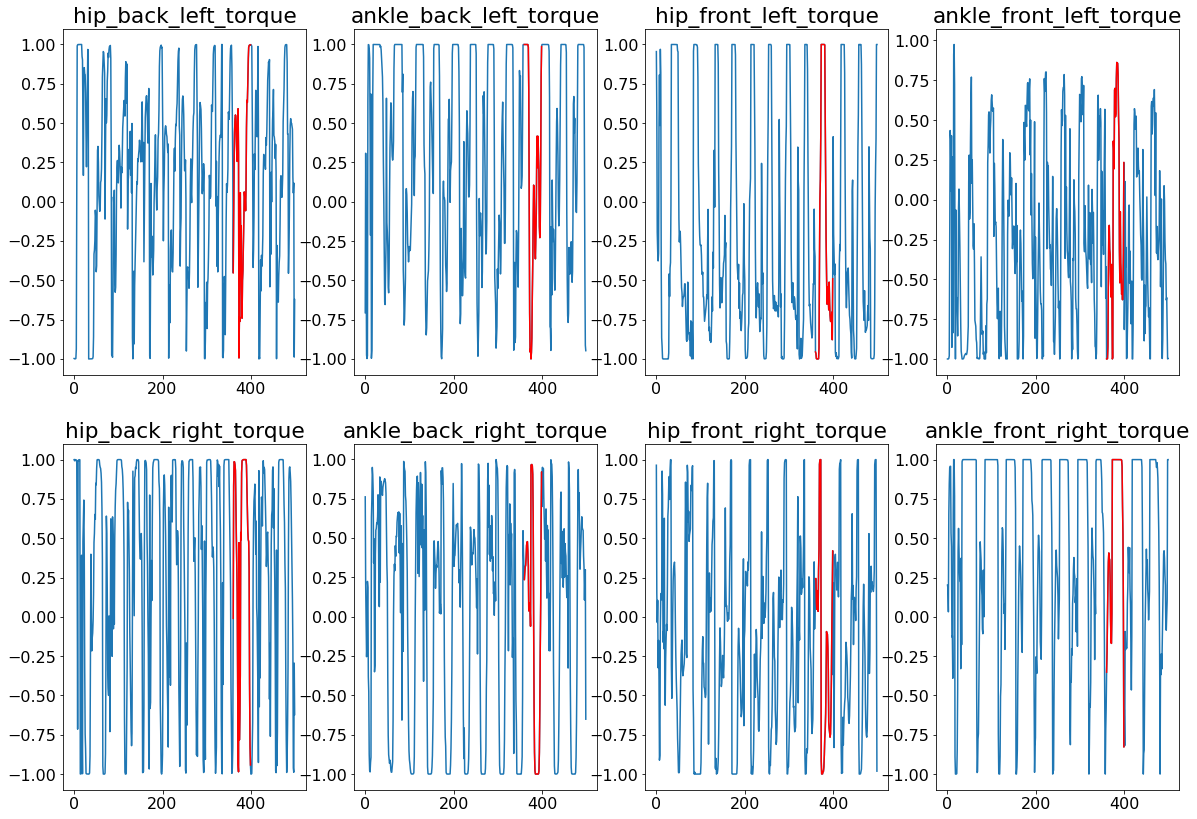

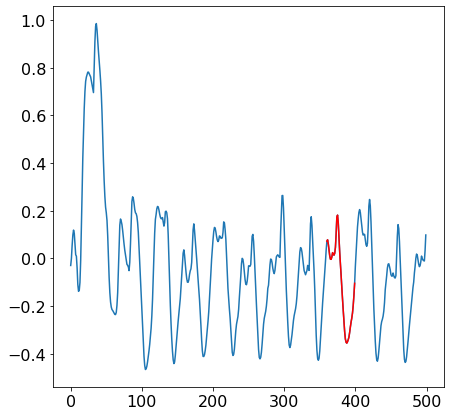

In [42]:
from mpl_toolkits import mplot3d
ind_start = 40
ind_xml = 1
ind_time1 = 360
ind_time2 = 400
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2])

# ax.scatter(projected[ind_time,0],projected[ind_time,1],projected[ind_time,2],c='r',s=100)
# ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])
ax.plot(projected1[ind_time1:ind_time2,0],projected1[ind_time1:ind_time2,1],projected1[ind_time1:ind_time2,2],c='r')

# ax.plot(projected2[ind_start:,0],projected2[ind_start:,1],projected2[ind_start:,2])
# ax.plot(projected3[ind_start:,0],projected3[ind_start:,1],projected3[ind_start:,2])
ax.view_init(elev=10., azim=0)

fig,ax = plt.subplots(2,4,figsize=[20,14])

cc = 0
for ii in range(2):
    for jj in range(4):
        ax[ii,jj].plot(act_all[ind_xml,:500,cc])
        ax[ii,jj].plot(np.arange(ind_time1,ind_time2),act_all[ind_xml,ind_time1:ind_time2,cc],c='r')
        ax[ii,jj].set_title(action_components[cc])
        cc += 1

In [46]:
ind_back_left_contact = state_components.index('back_left_foot_contact')

ind_angles = [ind for ind,state_name in enumerate(state_components) if '_angle' in state_name]

In [47]:
ind_angles

[8, 10, 12, 14, 16, 18, 20, 22]

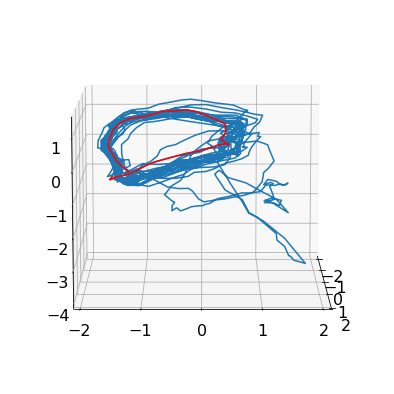

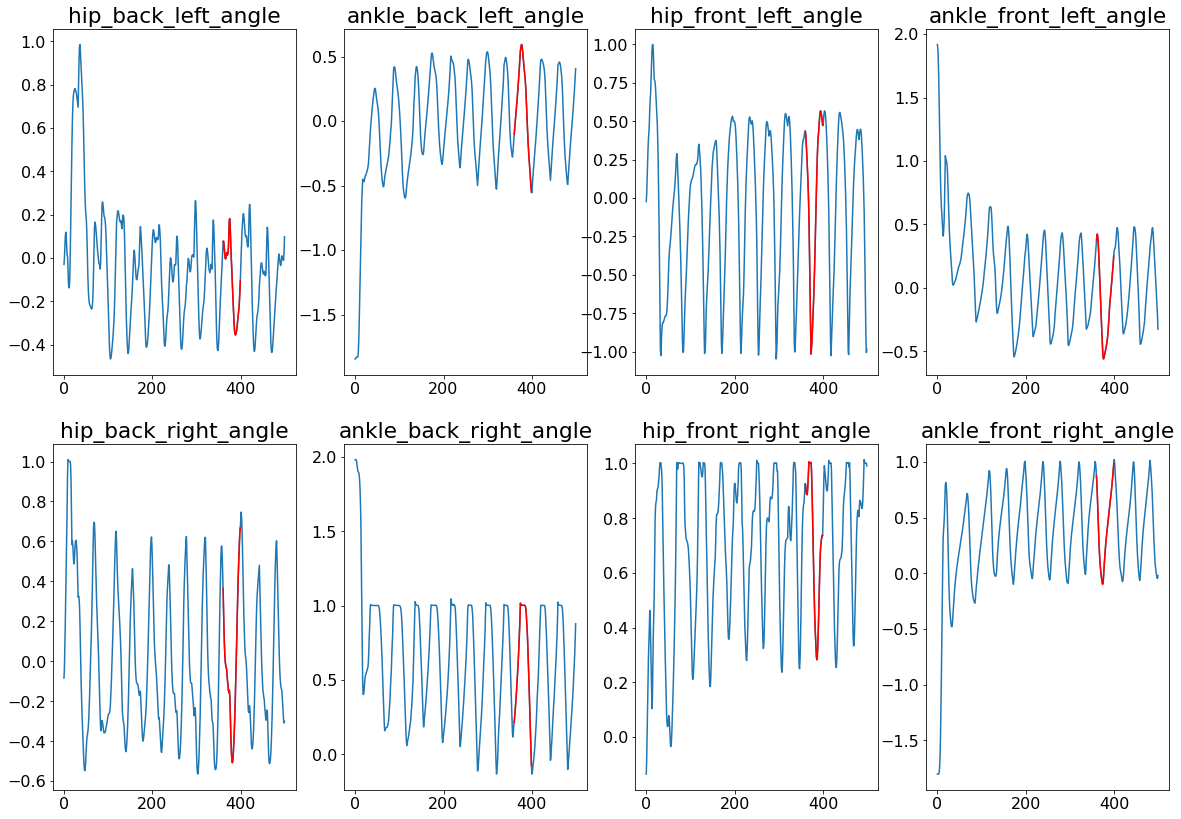

In [52]:
from mpl_toolkits import mplot3d
ind_start = 0
ind_xml = 1
ind_time1 = 360
ind_time2 = 400
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2])

# ax.scatter(projected[ind_time,0],projected[ind_time,1],projected[ind_time,2],c='r',s=100)
# ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])
ax.plot(projected1[ind_time1:ind_time2,0],projected1[ind_time1:ind_time2,1],projected1[ind_time1:ind_time2,2],c='r')

# ax.plot(projected2[ind_start:,0],projected2[ind_start:,1],projected2[ind_start:,2])
# ax.plot(projected3[ind_start:,0],projected3[ind_start:,1],projected3[ind_start:,2])
ax.view_init(elev=10., azim=0)

fig,ax = plt.subplots(2,4,figsize=[20,14])

cc = 0
for ii in range(2):
    for jj in range(4):
        ax[ii,jj].plot(obs_all[ind_xml,:500,0,ind_angles[cc]])
        ax[ii,jj].plot(np.arange(ind_time1,ind_time2),obs_all[ind_xml,ind_time1:ind_time2,0,ind_angles[cc]],c='r')
        ax[ii,jj].set_title(state_components[ind_angles[cc]])
        cc += 1


In [41]:
obs_all.shape

(100, 1000, 1, 28)

In [37]:
state_components

['z',
 'sin(angle_to_target)',
 'cos(angle_to_target)',
 'vx',
 'vy',
 'vz',
 'r',
 'p',
 'hip_back_left_angle',
 'hip_back_left_velocity',
 'ankle_back_left_angle',
 'ankle_back_left_velocity',
 'hip_front_left_angle',
 'hip_front_left_velocity',
 'ankle_front_left_angle',
 'ankle_front_left_velocity',
 'hip_back_right_angle',
 'hip_back_right_velocity',
 'ankle_back_right_angle',
 'ankle_back_right_velocity',
 'hip_front_right_angle',
 'hip_front_right_velocity',
 'ankle_front_right_angle',
 'ankle_front_right_velocity',
 'back_left_foot_contact',
 'front_left_foot_contact',
 'back_right_foot_contact',
 'front_right_foot_contact']

In [ ]:
from mpl_toolkits import mplot3d
ind_start = 40
ind_xml = 1
ind_time1 = 360
ind_time2 = 400
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2])

# ax.scatter(projected[ind_time,0],projected[ind_time,1],projected[ind_time,2],c='r',s=100)
# ax.plot(projected[ind_time1:ind_time2,0],projected[ind_time1:ind_time2,1],projected[ind_time1:ind_time2,2],c='r')

ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])
ax.plot(projected1[ind_time1:ind_time2,0],projected1[ind_time1:ind_time2,1],projected1[ind_time1:ind_time2,2],c='r')

# ax.plot(projected2[ind_start:,0],projected2[ind_start:,1],projected2[ind_start:,2])
# ax.plot(projected3[ind_start:,0],projected3[ind_start:,1],projected3[ind_start:,2])
ax.view_init(elev=10., azim=0)

fig,ax = plt.subplots(2,4,figsize=[20,14])

cc = 0
for ii in range(2):
    for jj in range(4):
        ax[ii,jj].plot(act_all[ind_xml,:500,cc])
        ax[ii,jj].plot(np.arange(ind_time1,ind_time2),act_all[ind_xml,ind_time1:ind_time2,cc],c='r')
        ax[ii,jj].set_title(action_components[cc])
        cc += 1

(1000, 288)


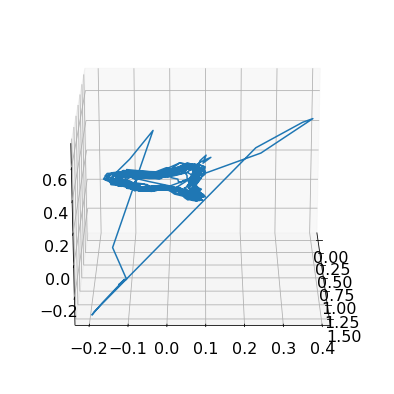

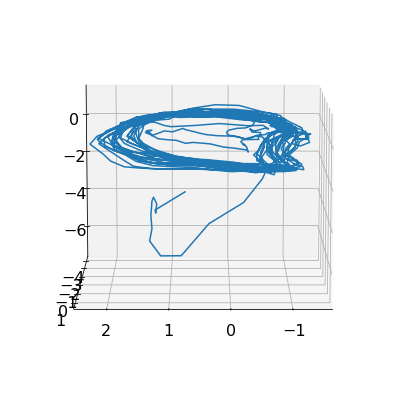

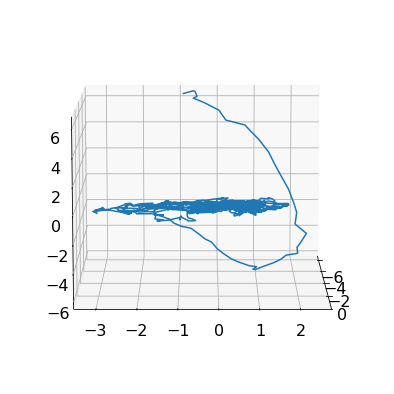

In [12]:
# from deeptime.data import ellipsoids

# data = ellipsoids(seed=17)

# discrete_trajectory = data.discrete_trajectory(n_steps=1000)

# feature_trajectory = data.map_discrete_to_observations(discrete_trajectory)

feature_trajectory = attention_episode.reshape(attention_episode.shape[0],-1)

print(feature_trajectory.shape)

vamp = VAMP(dim=3, lagtime=1)
vamp = vamp.fit(feature_trajectory).fetch_model()
vamp_projection = vamp.transform(feature_trajectory)


tica = TICA(dim=3, lagtime=1)
tica = tica.fit(feature_trajectory).fetch_model()
tica_projection = tica.transform(feature_trajectory)


from sklearn.decomposition import PCA
pca = PCA(n_components=3)
projected = pca.fit_transform(attention_episode.reshape(attention_episode.shape[0],-1))


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(projected[:,0],projected[:,1],projected[:,2])
ax.view_init(elev=20., azim=0)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(vamp_projection[:,0],vamp_projection[:,1],vamp_projection[:,2])
ax.view_init(elev=10., azim=90)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(tica_projection[:,0],tica_projection[:,1],tica_projection[:,2])
ax.view_init(elev=10., azim=0)

(1000, 2)


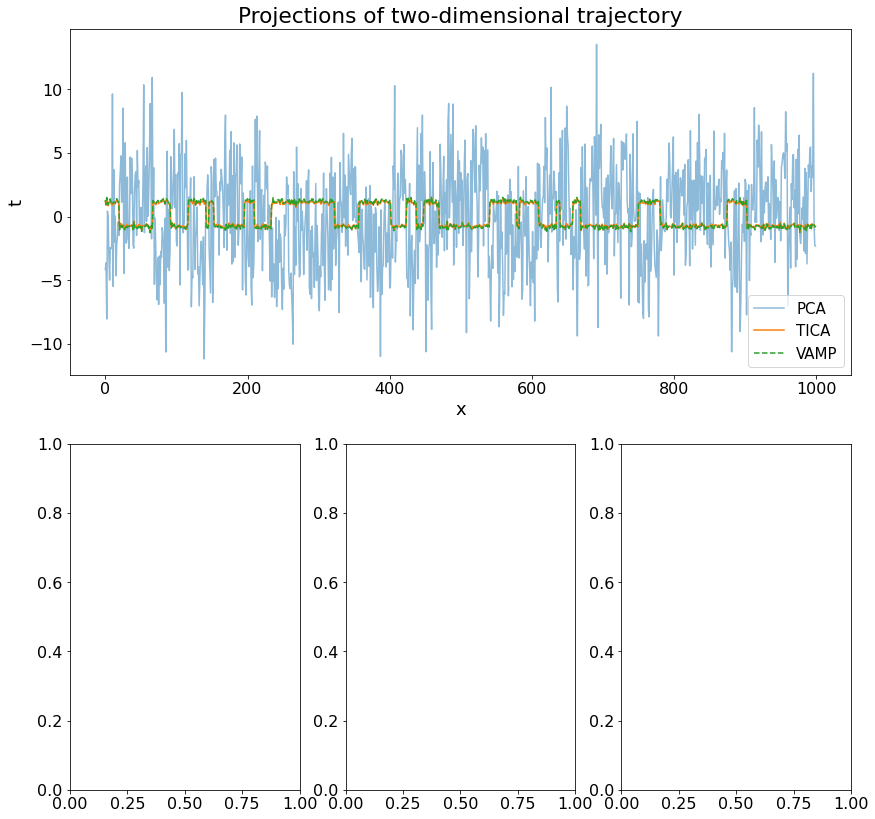

In [119]:
# vamp = VAMP(dim=1, lagtime=1)

# vamp = vamp.fit(attention_episode.reshape(attention_episode.shape[0],-1)).fetch_model()

# vamp_projection = vamp.transform(attention_episode.reshape(attention_episode.shape[0],-1))

# dxy_vamp = vamp.singular_vectors_left[:, 0]  # dominant vamp component

# feature_trajectory = attention_episode.reshape(attention_episode.shape[0],-1)

from deeptime.data import ellipsoids

data = ellipsoids(seed=17)

discrete_trajectory = data.discrete_trajectory(n_steps=1000)

feature_trajectory = data.map_discrete_to_observations(discrete_trajectory)
print(feature_trajectory.shape)

vamp = VAMP(dim=1, lagtime=1)

vamp = vamp.fit(feature_trajectory).fetch_model()

vamp_projection = vamp.transform(feature_trajectory)

dxy_vamp = vamp.singular_vectors_left[:, 0]  # dominant vamp component


tica = TICA(dim=1, lagtime=1)

tica = tica.fit(feature_trajectory).fetch_model()

tica_projection = tica.transform(feature_trajectory)

dxy_tica = tica.singular_vectors_left[:, 0]  # dominant tica component


pca = PCA(n_components=1)

pca.fit(feature_trajectory)

pca_projection = pca.transform(feature_trajectory)

dxy_pca = pca.components_[0]  # dominant pca component


f = plt.figure(constrained_layout=False, figsize=(14, 14))

gs = f.add_gridspec(nrows=2, ncols=3)

ax_projections = f.add_subplot(gs[0, :])

ax_tica = f.add_subplot(gs[1, 0])

ax_vamp = f.add_subplot(gs[1, 1])

ax_pca = f.add_subplot(gs[1, 2])


ax_projections.set_title("Projections of two-dimensional trajectory")

ax_projections.set_xlabel('x')

ax_projections.set_ylabel('t')


ax_projections.plot(pca_projection, label='PCA', alpha=.5)

ax_projections.plot(tica_projection, label='TICA')

ax_projections.plot(vamp_projection, label='VAMP', linestyle='dashed')

ax_projections.legend()


# plot_dominant_component(ax_pca, dxy_pca, 'Samples with dominant PCA component')

# plot_dominant_component(ax_tica, dxy_tica, 'Samples with dominant TICA component')

# plot_dominant_component(ax_vamp, dxy_vamp, 'Samples with dominant VAMP component')

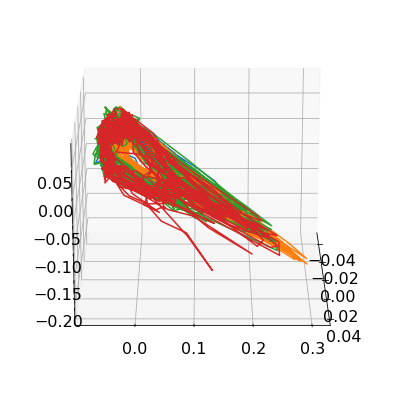

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
# projected = pca.fit_transform(attention_episode.reshape(attention_episode.shape[0],-1))

### Fit on all time points
fitted = pca.fit(attention_episode_all_stack.reshape(-1,attention_episode_all_stack.shape[2]*attention_episode_all_stack.shape[3]))
projected = fitted.transform(attention_episode_all_stack[0,:,:,:].reshape(attention_episode_all_stack.shape[1],-1))
projected1 = fitted.transform(attention_episode_all_stack[1,:,:,:].reshape(attention_episode_all_stack.shape[1],-1))
projected2 = fitted.transform(attention_episode_all_stack[2,:,:,:].reshape(attention_episode_all_stack.shape[1],-1))
projected3 = fitted.transform(attention_episode_all_stack[3,:,:,:].reshape(attention_episode_all_stack.shape[1],-1))
projected4 = fitted.transform(attention_episode_all_stack[4,:,:,:].reshape(attention_episode_all_stack.shape[1],-1))

ind_start = 40
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2])
ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])
ax.plot(projected2[ind_start:,0],projected2[ind_start:,1],projected2[ind_start:,2])
ax.plot(projected3[ind_start:,0],projected3[ind_start:,1],projected3[ind_start:,2])
ax.plot(projected4[ind_start:,0],projected4[ind_start:,1],projected4[ind_start:,2])
ax.view_init(elev=20., azim=0)


In [234]:
projected1 = pca.fit_transform(attention_episode_all_stack[1,:,:,:].reshape(attention_episode.shape[0],-1))
projected2 = pca.fit_transform(attention_episode_all_stack[2,:,:,:].reshape(attention_episode.shape[0],-1))
projected3 = pca.fit_transform(attention_episode_all_stack[3,:,:,:].reshape(attention_episode.shape[0],-1))

In [217]:
projected.shape

(1000, 3)

In [220]:
from mpl_toolkits import mplot3d

In [277]:
perturbation_summary['values'][0]

[-0.06039208582682565,
 -0.02863531698369043,
 -0.0883700189501667,
 0.040567299059667355,
 -0.07674055615893353,
 0.07637571047544711,
 0.04896325916705218,
 -0.013245526514070627,
 -0.022817563635333972]

In [276]:
perturbation_summary['values'][1]

[-0.001892791390350479,
 0.035316924849233544,
 0.049941061358392436,
 0.05688120146630074,
 -0.07262530315987711,
 -0.051746807034444876,
 0.09064155402283222,
 0.08406258909067793,
 0.09896039964457715]

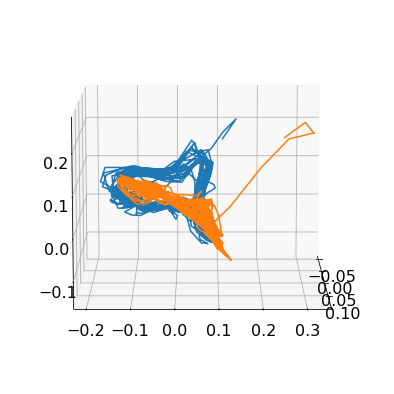

In [285]:
ind_start = 30
ind_time = 90
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(projected[ind_start:,0],projected[ind_start:,1],projected[ind_start:,2])

# ax.scatter(projected[ind_time,0],projected[ind_time,1],projected[ind_time,2],c='r',s=100)

ax.plot(projected1[ind_start:,0],projected1[ind_start:,1],projected1[ind_start:,2])
# ax.plot(projected2[ind_start:,0],projected2[ind_start:,1],projected2[ind_start:,2])
# ax.plot(projected3[ind_start:,0],projected3[ind_start:,1],projected3[ind_start:,2])
ax.view_init(elev=10., azim=0)

### Re-order attention action component

In [63]:
ordered_action_components = [
    "hip_back_left_torque",
    "hip_back_right_torque",
    "hip_front_left_torque",
    "hip_front_right_torque",
    "ankle_back_left_torque",
    "ankle_back_right_torque",
    "ankle_front_left_torque",
    "ankle_front_right_torque"
]

def order_attention_map_4d(attention_episode,ordered_state_components,ordered_action_components):
    action_ordered_mean_attention = np.zeros_like(attention_episode)
    ordered_mean_attention = np.zeros_like(attention_episode)
    for idx, c in enumerate(ordered_action_components):
        old_idx = action_components.index(c)
        action_ordered_mean_attention[:,:,idx, :] = attention_episode[:,:,old_idx, :]
    for idx, c in enumerate(ordered_state_components + ordered_action_components):
        if c in state_components:
            old_idx = state_components.index(c)
        else:
            old_idx = len(state_components) + action_components.index(c)
        ordered_mean_attention[:,:,:, idx] = action_ordered_mean_attention[:,:,:, old_idx]
    return ordered_mean_attention

def order_attention_map_3d(attention_episode,ordered_state_components,ordered_action_components):
    action_ordered_mean_attention = np.zeros_like(attention_episode)
    ordered_mean_attention = np.zeros_like(attention_episode)
    for idx, c in enumerate(ordered_action_components):
        old_idx = action_components.index(c)
        action_ordered_mean_attention[:,idx, :] = attention_episode[:,old_idx, :]
    for idx, c in enumerate(ordered_state_components + ordered_action_components):
        if c in state_components:
            old_idx = state_components.index(c)
        else:
            old_idx = len(state_components) + action_components.index(c)
        ordered_mean_attention[:,:, idx] = action_ordered_mean_attention[:,:, old_idx]
    return ordered_mean_attention

ordered_attention_episode_all_stack = order_attention_map_4d(attention_episode_all_stack,state_components,ordered_action_components)

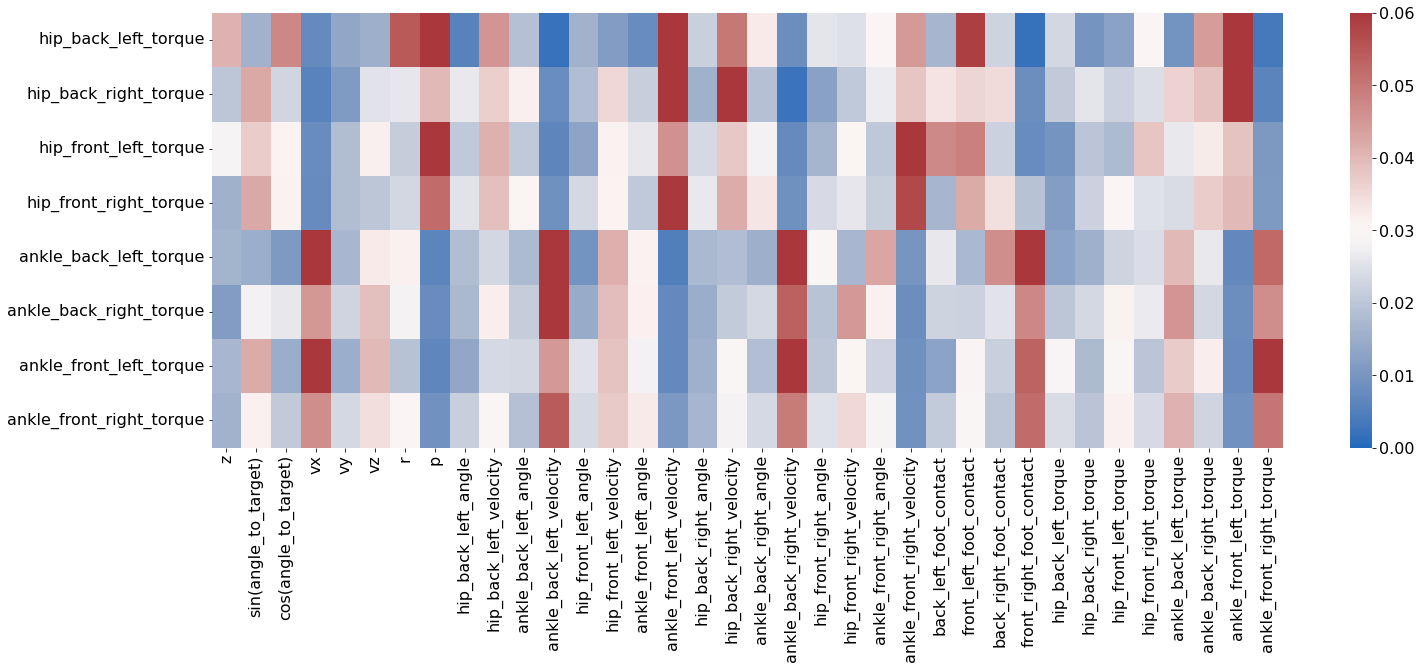

In [71]:
ind_start = 0  ## This is to remove the first attention step when initialized

ordered_attention_episode_all_stack_mean = ordered_attention_episode_all_stack.mean(axis=0)
# print(ordered_attention_episode_all_stack_mean.shape)
ordered_attention_episode_all_stack_mean = ordered_attention_episode_all_stack_mean[ind_start:,:,:].mean(axis=0)
# print(ordered_attention_episode_all_stack_mean.shape)
df_mean = pd.DataFrame(ordered_attention_episode_all_stack_mean)
df_mean.index = ordered_action_components
df_mean.columns = state_components+ordered_action_components #[action_label[:-7] for action_label in ordered_action_components]

### sigma 0.1
plt.figure(figsize=[24,8])
g = sns.heatmap(data=df_mean,vmin=0,vmax=0.06,cmap="vlag")

### Get component for specific joint

In [68]:
all_components = state_components+ordered_action_components
index_hip_back_left = [idx for idx, s in enumerate(all_components) if ('hip_back_left' in s) and ('torque' not in s)]
index_hip_back_right = [idx for idx, s in enumerate(all_components) if ('hip_back_right' in s) and ('torque' not in s)]
index_hip_front_left = [idx for idx, s in enumerate(all_components) if ('hip_front_left' in s) and ('torque' not in s)]
index_hip_front_right = [idx for idx, s in enumerate(all_components) if ('hip_front_right' in s) and ('torque' not in s)]

index_ankle_back_left = [idx for idx, s in enumerate(all_components) if ('ankle_back_left' in s) and ('torque' not in s)]
index_ankle_back_right = [idx for idx, s in enumerate(all_components) if ('ankle_back_right' in s) and ('torque' not in s)]
index_ankle_front_left = [idx for idx, s in enumerate(all_components) if ('ankle_front_left' in s) and ('torque' not in s)]
index_ankle_front_right = [idx for idx, s in enumerate(all_components) if ('ankle_front_right' in s) and ('torque' not in s)]


all_list = [index_hip_back_left, index_hip_back_right, index_hip_front_left, index_hip_front_right, index_ankle_back_left, index_ankle_back_right, index_ankle_front_left, index_ankle_front_right]

In [69]:
## Take the mean of the 3 components for each joint
attention_mean_all = np.zeros((ordered_attention_episode_all_stack.shape[2],len(all_list)))
for ii in range(ordered_attention_episode_all_stack.shape[2]):
    for jj in range(len(all_list)):
        attention_mean_all[ii,jj] = ordered_attention_episode_all_stack.mean(axis=1)[:,ii,all_list[jj]].mean()
        # attention_mean_all[ii,jj] = ordered_attention_episode_all_stack.mean(axis=1)[:,ii,all_list[jj]].sum()

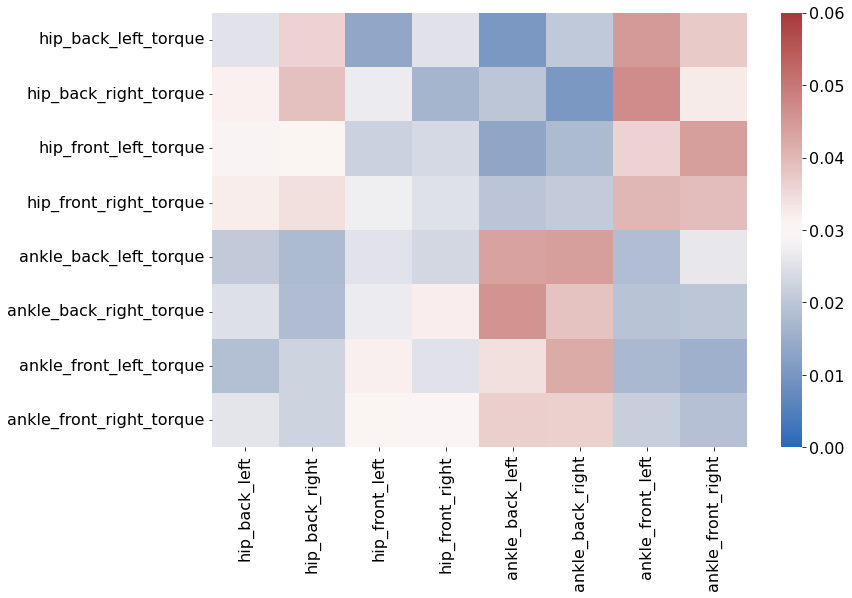

In [205]:
df_mean = pd.DataFrame(attention_mean_all)
df_mean.index = ordered_action_components
df_mean.columns = [action_label[:-7] for action_label in ordered_action_components]

### sigma 0.1
plt.figure(figsize=[12,8])
g = sns.heatmap(data=df_mean,vmin=0,vmax=0.06,cmap="vlag")

In [77]:
import networkx as nx

### Single graph - demo

In [69]:
print('List of actions')
print(ordered_action_components)

List of actions
['hip_back_left_torque', 'hip_back_right_torque', 'hip_front_left_torque', 'hip_front_right_torque', 'ankle_back_left_torque', 'ankle_back_right_torque', 'ankle_front_left_torque', 'ankle_front_right_torque']


In [70]:
## Example of matrix with all 0.01 connections except two with connection equal 1
attention_matrix_demo = np.zeros_like(attention_mean_all)+0.01
attention_matrix_demo[0,2] = 0.93
attention_matrix_demo[1,5] = 0.93
attention_matrix_demo[2,0] = 0.93
attention_matrix_demo[5,1] = 0.93
print(attention_matrix_demo)

# ### Normalize each column wrt to the sum of the column
# for ii in range(attention_matrix_demo.shape[1]):
#     attention_matrix_demo[:,ii] = attention_matrix_demo[:,ii]/np.sum(attention_matrix_demo[:,ii]) 
# print(attention_matrix_demo)

[[0.01 0.01 0.93 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.93 0.01 0.01]
 [0.93 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.93 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]


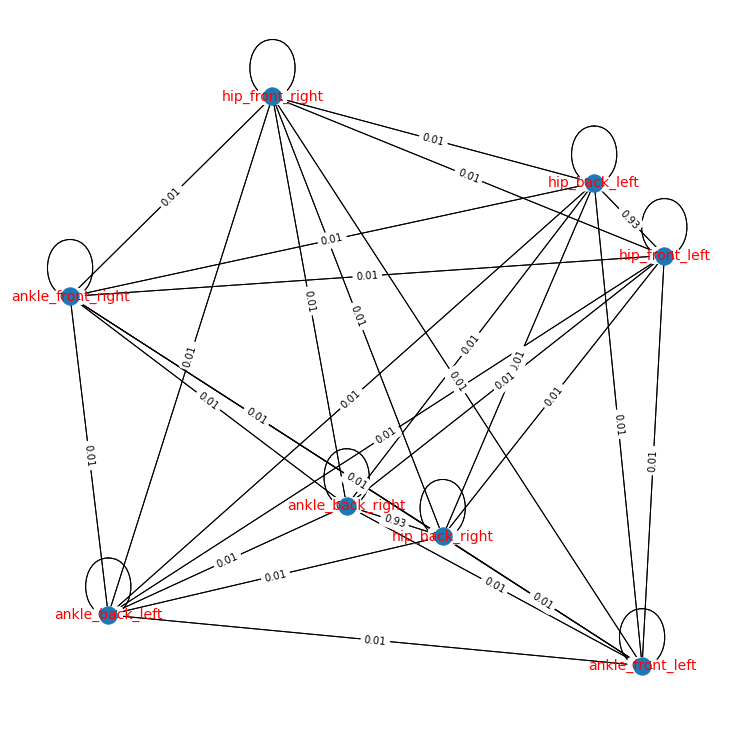

In [71]:
G = nx.from_numpy_matrix(attention_matrix_demo)
pos = nx.spring_layout(G, dim=2, seed=18)

plt.figure(figsize=[10,10])
nx.draw(
    G, pos,
    # labels={node: ordered_action_components[node] for node in G.nodes()}
)

new_labels = {}    
for node in G.nodes():
    new_labels[node] = ordered_action_components[node][:-7]
nx.draw_networkx_labels(G,pos,new_labels,font_size=14,font_color='r')

nx.draw_networkx_edges(G,pos)
labels = nx.get_edge_attributes(G,'weight')
for key,value in labels.items():
    labels[key] = round(value,2)
_ = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

### Single graph (Sum attention on the two edges)

In [187]:
### Normalize each column wrt to the sum of the column
attention_mean_all_norm = np.zeros_like(attention_mean_all)
for ii in range(attention_mean_all.shape[0]):
    attention_mean_all_norm[ii,:] = attention_mean_all[ii,:]/np.sum(attention_mean_all[ii,:])
    

symmetric_attention = attention_mean_all + attention_mean_all.T

## Normalize now everything between 1 and 0
symmetric_attention_norm = (symmetric_attention - symmetric_attention.min())/(symmetric_attention.max() - symmetric_attention.min())

# symmetric_attention = attention_mean_all + attention_mean_all.T

# ### Normalize each column wrt to the sum of the column
# symmetric_attention_norm = np.zeros_like(symmetric_attention)
# for ii in range(symmetric_attention.shape[0]):
#     symmetric_attention_norm[ii,:] = symmetric_attention[ii,:]/np.sum(symmetric_attention[ii,:]) 
# print(symmetric_attention_norm)

### Create graph and spring layout
G = nx.from_numpy_matrix(symmetric_attention_norm)
pos = nx.spring_layout(G, dim=2, seed=18)

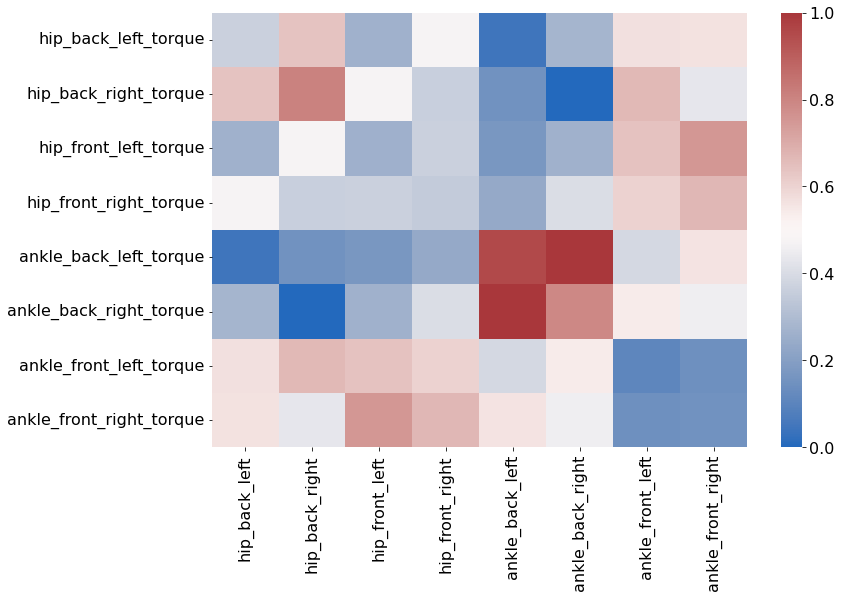

In [214]:
df_mean = pd.DataFrame(symmetric_attention_norm)
df_mean.index = ordered_action_components
df_mean.columns = [action_label[:-7] for action_label in ordered_action_components]

### sigma 0.1
plt.figure(figsize=[12,8])
g = sns.heatmap(data=df_mean,vmin=0,vmax=1,cmap="vlag")

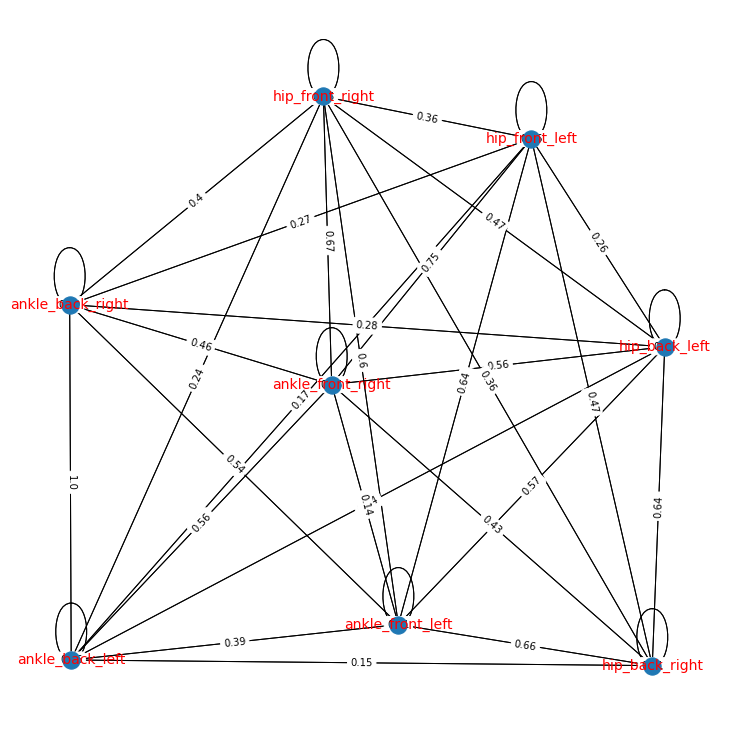

In [188]:
plt.figure(figsize=[10,10])

nx.draw(
    G, pos,
    # labels={node: ordered_action_components[node] for node in G.nodes()}
)
nx.draw_networkx_edges(G,pos)

new_labels = {}    
for node in G.nodes():
    new_labels[node] = ordered_action_components[node][:-7]
nx.draw_networkx_labels(G,pos,new_labels,font_size=14,font_color='r')

labels = nx.get_edge_attributes(G,'weight')
for key,value in labels.items():
    labels[key] = round(value,2)
_ = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

#### Optimal spring layout based on the energy computed as the mean of all euclidian distance betwen nodes

In [189]:
def compute_energy_spring(pos,edge_weights):
    energy_tmp = []
    for node1 in pos:
        for node2 in range(node1,len(pos)):
            # print(node1,node2,edge_weights[node1,node2])
            try:
                energy_tmp.append(0.5*edge_weights[node1,node2]*np.linalg.norm(abs(pos[node1]-pos[node2])))
            except:
                energy_tmp.append(0)
    energy_tmp = np.sum(energy_tmp)
    return energy_tmp

In [190]:
edge_weights = nx.get_edge_attributes(G,'weight')

In [191]:
## Optimal spring layout
energy = []
for ii in range(1000):
    pos = nx.spring_layout(G, dim=2, seed=ii)
    # dist_tmp = [np.linalg.norm(abs(pos[node1]-pos[node2])) for node1 in pos for node2 in pos]
    # dist_tmp = np.array(dist_tmp).mean()
    energy_tmp = compute_energy_spring(pos,edge_weights)
    energy.append(energy_tmp)

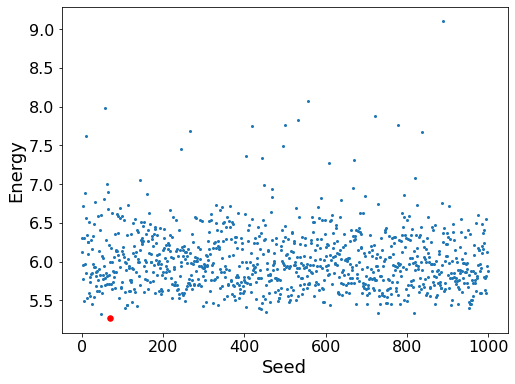

In [203]:
plt.figure(figsize=[8,6])
plt.scatter(np.arange(len(energy)),energy,s=4)
plt.xlabel('Seed')
plt.ylabel('Energy')
ind_min = np.argmin(energy)
plt.scatter(ind_min,energy[ind_min],s=30,color='r')

In [199]:
ind_min = np.argmin(energy)
print('Minimum energy',energy[ind_min])
pos = nx.spring_layout(G, dim=2, seed=int(ind_min))

Minimum energy 5.271645944542866


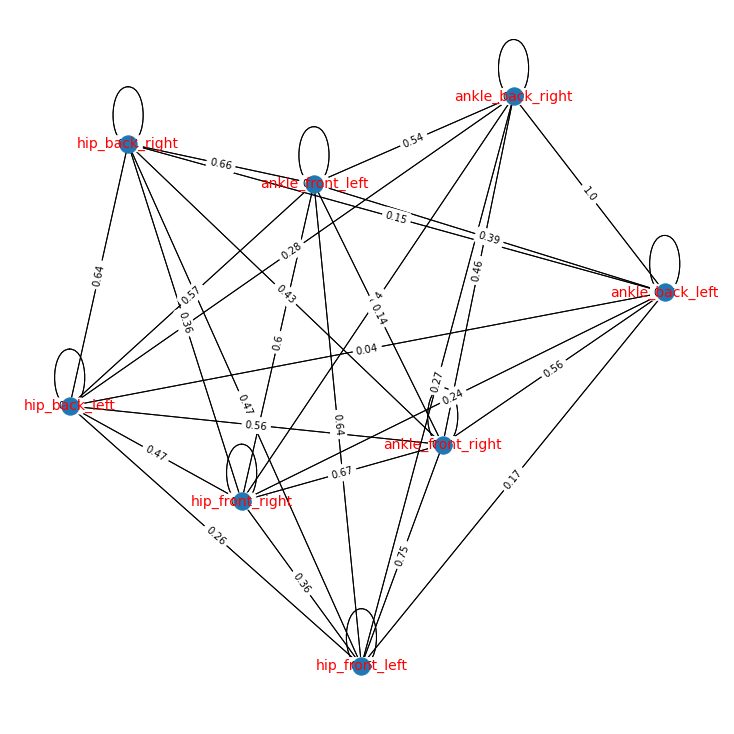

In [200]:
plt.figure(figsize=[10,10])

nx.draw(
    G, pos,
    # labels={node: ordered_action_components[node] for node in G.nodes()}
)
nx.draw_networkx_edges(G,pos)

new_labels = {}    
for node in G.nodes():
    new_labels[node] = ordered_action_components[node][:-7]
nx.draw_networkx_labels(G,pos,new_labels,font_size=14,font_color='r')

labels = nx.get_edge_attributes(G,'weight')
for key,value in labels.items():
    labels[key] = round(value,2)
_ = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

#### Kamada kawai

In [ ]:
### Position nodes using Kamada-Kawai path-length cost-function.
pos = nx.kamada_kawai_layout(G)

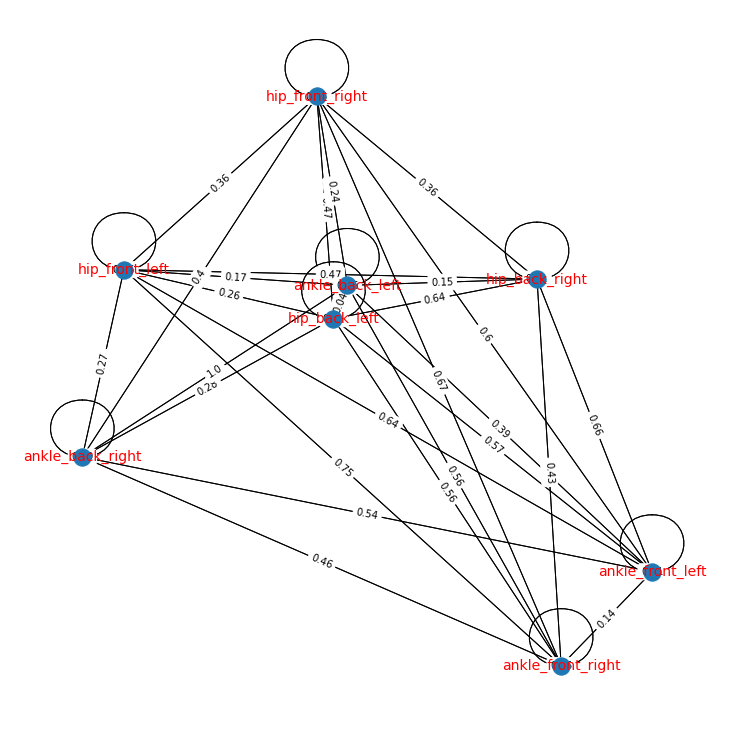

In [ ]:
## kamada_kawai_layout
plt.figure(figsize=[10,10])

nx.draw(
    G, pos,
    # labels={node: ordered_action_components[node] for node in G.nodes()}
)
nx.draw_networkx_edges(G,pos)

new_labels = {}    
for node in G.nodes():
    new_labels[node] = ordered_action_components[node][:-7]
nx.draw_networkx_labels(G,pos,new_labels,font_size=14,font_color='r')

labels = nx.get_edge_attributes(G,'weight')
for key,value in labels.items():
    labels[key] = round(value,2)
_ = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [179]:
# dist_tmp = [np.linalg.norm(abs(pos[node1]-pos[node2])) for node1 in pos for node2 in pos]
# dist_tmp = np.array(dist_tmp).mean()
# print(dist_tmp)

energy_tmp = compute_energy_spring(pos,edge_weights)
print(energy_tmp)

6.822969598699885


#### Spectral layout

In [123]:
dist_tmp

0.7722785877090546

In [142]:
pos = nx.spectral_layout(G)

dist_tmp = [np.linalg.norm(abs(pos[node1]-pos[node2])) for node1 in pos for node2 in pos]
dist_tmp = np.array(dist_tmp).mean()
print(dist_tmp)

0.7722785877090546


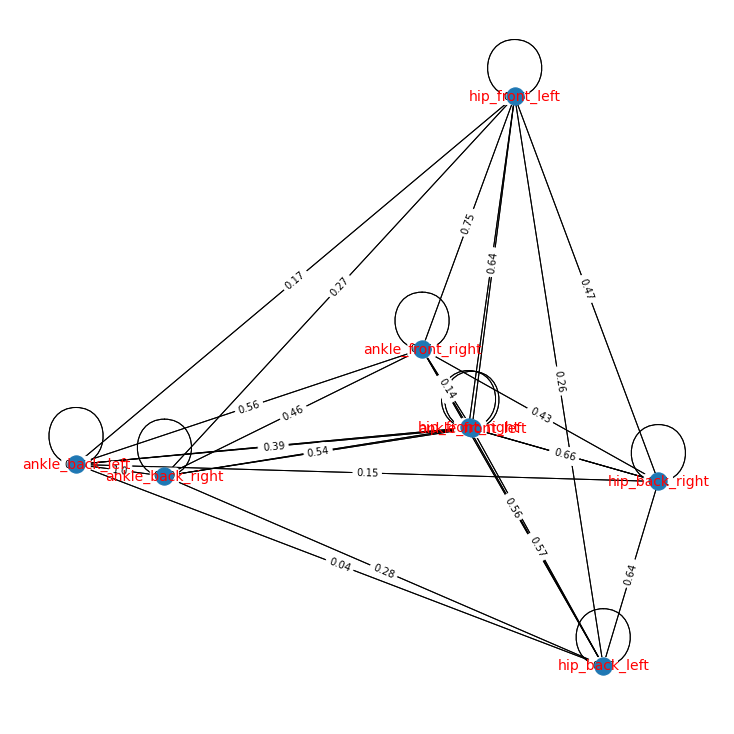

In [97]:
plt.figure(figsize=[10,10])

nx.draw(
    G, pos,
    # labels={node: ordered_action_components[node] for node in G.nodes()}
)
nx.draw_networkx_edges(G,pos)

new_labels = {}    
for node in G.nodes():
    new_labels[node] = ordered_action_components[node][:-7]
nx.draw_networkx_labels(G,pos,new_labels,font_size=14,font_color='r')

labels = nx.get_edge_attributes(G,'weight')
for key,value in labels.items():
    labels[key] = round(value,2)
_ = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

## Digraph

In [72]:
joint_list = ['HB_L','HB_R','HF_L','HF_R','AB_L','AB_R','AF_L','AF_R']
# joint_list = ['HB_L','HB_R','HF_L','HF_R']
# joint_list = ['AB_L','AB_R','AF_L','AF_R']

In [74]:
attention_mean_all_norm = (attention_mean_all - attention_mean_all.min())/(attention_mean_all.max() - attention_mean_all.min())

### Normalize each column wrt to the sum of the column
# attention_mean_all_norm = np.zeros_like(attention_mean_all)
# for ii in range(symmetric_attention.shape[1]):
#     attention_mean_all_norm[:,ii] = attention_mean_all[:,ii]/np.sum(attention_mean_all[:,ii]) 
# print(attention_mean_all_norm)

## Normalize each column wrt to the sum of the column
for ii in range(attention_mean_all_norm.shape[0]):
    attention_mean_all_norm[ii,:] = attention_mean_all_norm[ii,:]/np.sum(attention_mean_all_norm[ii,:]) 
print(attention_mean_all_norm)

[[0.11548932 0.19623676 0.02475463 0.1139037  0.         0.07805121
  0.26366401 0.20790038]
 [0.15098068 0.20346025 0.11769873 0.04281924 0.06827    0.00059634
  0.25894107 0.15723369]
 [0.15135838 0.14944147 0.08701397 0.09695386 0.02291783 0.0538718
  0.18993239 0.2485103 ]
 [0.14011488 0.15254621 0.10795124 0.09306704 0.06002732 0.06828492
  0.19148522 0.18652317]
 [0.07566427 0.05370491 0.11046019 0.09358045 0.24487144 0.24863571
  0.05675718 0.11632584]
 [0.101115   0.05272176 0.1167215  0.15317376 0.24910234 0.19753609
  0.06265944 0.06697011]
 [0.06653223 0.09708086 0.17137313 0.11938591 0.19020856 0.25601274
  0.05715424 0.04225232]
 [0.10921355 0.08688564 0.14498932 0.14156854 0.18896733 0.18795517
  0.0800804  0.06034005]]


In [75]:
# df_mean = pd.DataFrame(attention_mean_all_norm)
# df_mean.index = ordered_action_components
# df_mean.columns = ordered_action_components

# ### sigma 0.1
# plt.figure(figsize=[12,8])
# g = sns.heatmap(data=df_mean,vmin=0,vmax=0.7,cmap="vlag")

In [78]:
G1 = nx.from_numpy_array(np.random.rand(len(joint_list),len(joint_list))>0.5)
fixed_positions_circular = nx.circular_layout(G1)

fixed_positions = {}
for ii,pos_tmp in enumerate(fixed_positions_circular):
    fixed_positions[joint_list[ii]] = fixed_positions_circular[ii]

In [82]:
G = nx.Graph()
# joint_list = ['HB_L','HB_R','HF_L','HF_R','AB_L','AB_R','AF_L','AF_R']


### Create edge connection
edge_list = []
for i,edge1 in enumerate(joint_list):
    for j,edge2 in enumerate(ordered_action_components):
        if joint_list == ['AB_L','AB_R','AF_L','AF_R']:
            edge_list.append((edge1,edge2,{'weight' : attention_mean_all_norm[4+i,j]}))
        else:
            edge_list.append((edge1,edge2,{'weight' : attention_mean_all_norm[i,j]}))

G.add_edges_from(edge_list)

### Update color of fixed and variable joints
color_map = []
for node in G:
    if node in joint_list:
        color_map.append('pink')
    else: 
        color_map.append('green')

### Create spring layout
pos=nx.spring_layout(G,pos=fixed_positions,fixed=joint_list,seed=5)


In [83]:
new_labels = {}    
for node in G.nodes():
    if node not in joint_list:
        #set the node name as the key and the label as its value 
        new_labels[node] = node[:-7]
    else:
        new_labels[node] = node

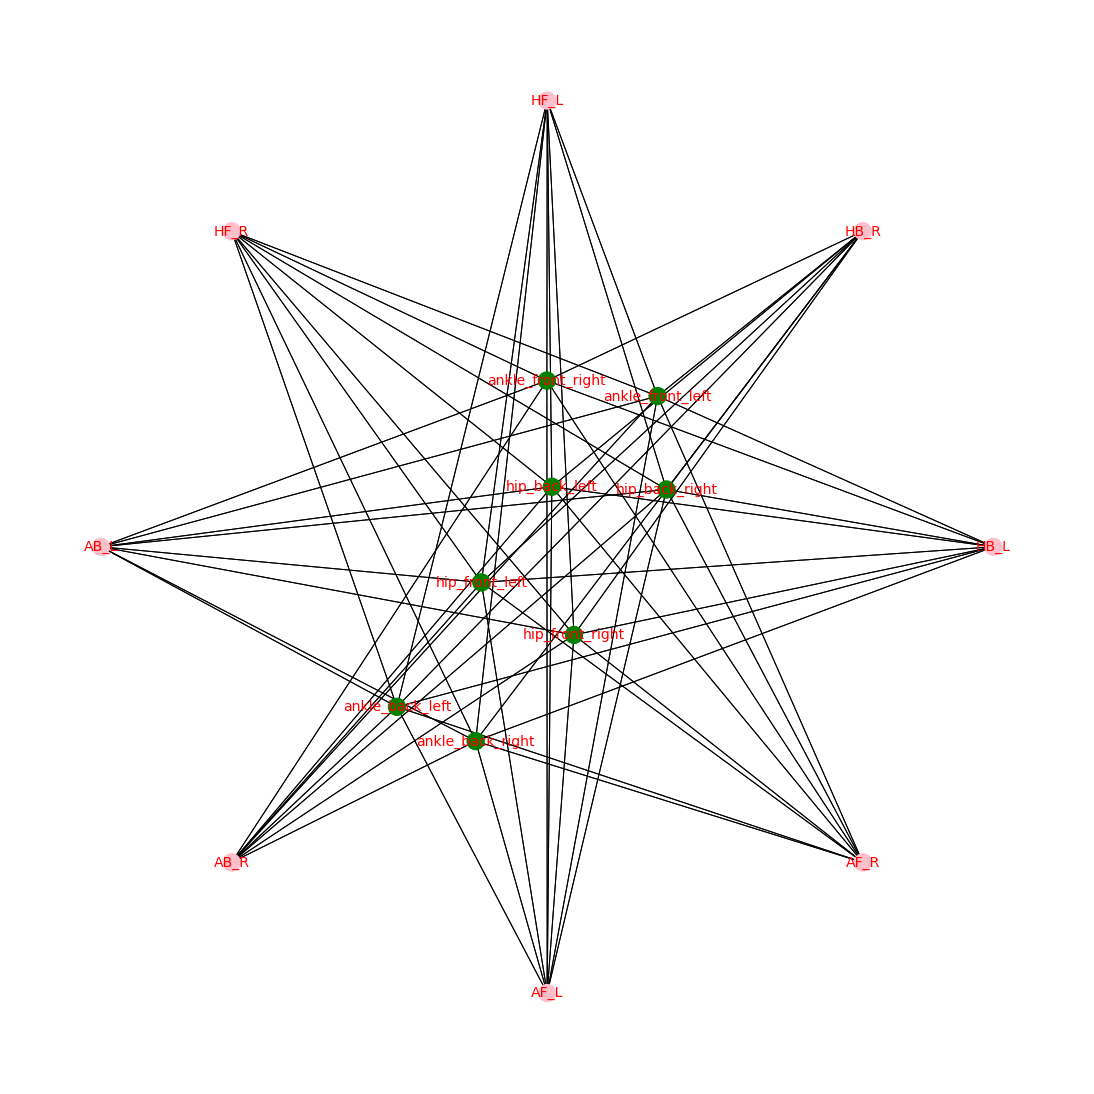

In [81]:
### ALL JOINTS
plt.figure(figsize=[15,15])
show_weights = False

nx.draw(
    G, pos,
    node_color=color_map,
    with_labels=False
    # labels={node: ordered_action_components[node] for node in G.nodes()}
)

nx.draw_networkx_labels(G,pos,new_labels,font_size=14,font_color='r')

nx.draw_networkx_edges(G,pos)

if show_weights:
    labels = nx.get_edge_attributes(G,'weight')
    for key,value in labels.items():
        labels[key] = round(value,2)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

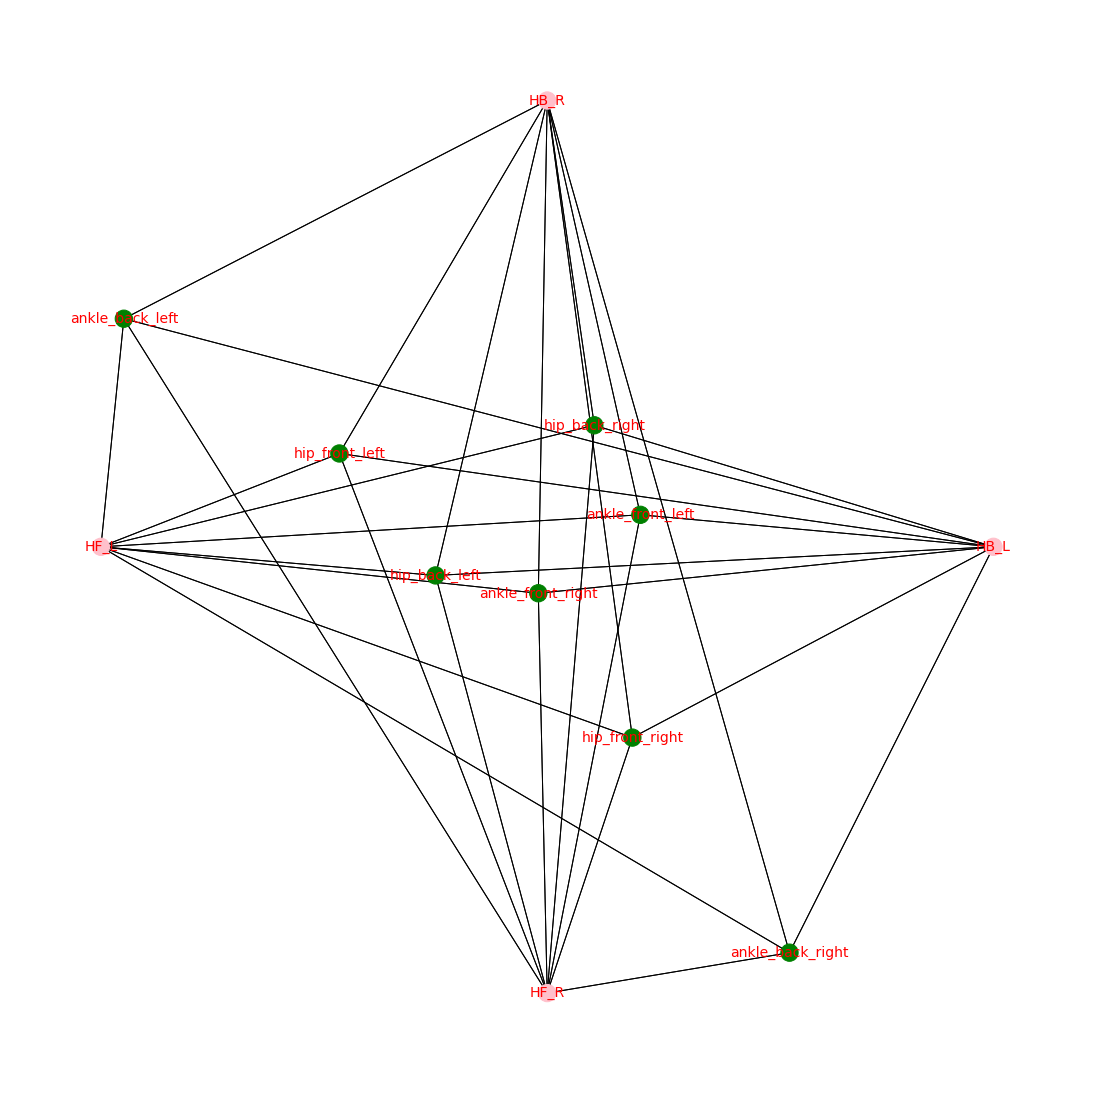

In [46]:
### HIP ONLY
plt.figure(figsize=[15,15])
show_weights = False

nx.draw(
    G, pos,
    node_color=color_map,
    with_labels=False
    # labels={node: ordered_action_components[node] for node in G.nodes()}
)

nx.draw_networkx_labels(G,pos,new_labels,font_size=14,font_color='r')

nx.draw_networkx_edges(G,pos)

if show_weights:
    labels = nx.get_edge_attributes(G,'weight')
    for key,value in labels.items():
        labels[key] = round(value,2)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

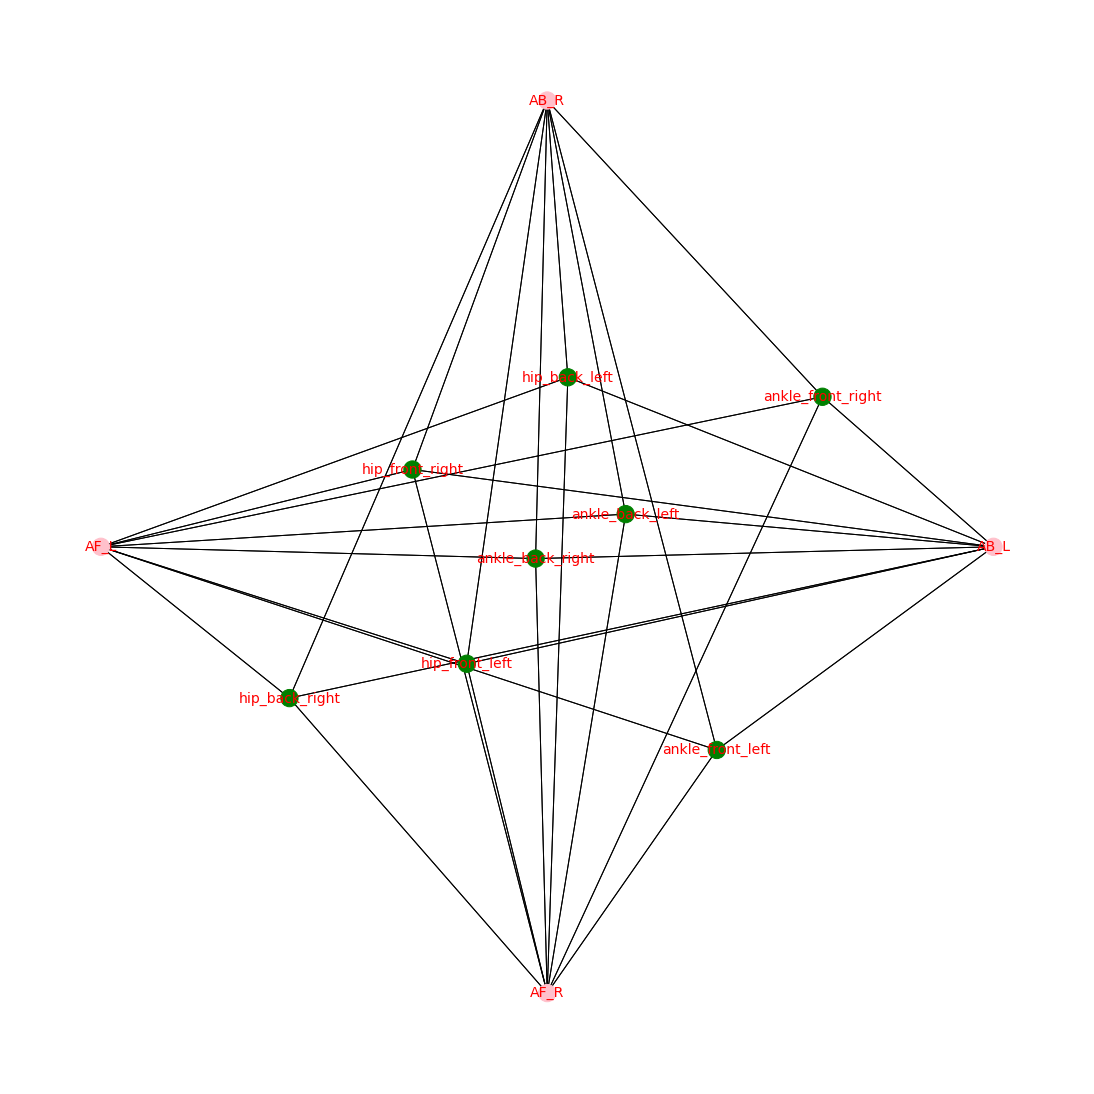

In [40]:

### ANKLE ONLY
plt.figure(figsize=[15,15])
show_weights = False

nx.draw(
    G, pos,
    node_color=color_map,
    with_labels=False
    # labels={node: ordered_action_components[node] for node in G.nodes()}
)

nx.draw_networkx_labels(G,pos,new_labels,font_size=14,font_color='r')

nx.draw_networkx_edges(G,pos)

if show_weights:
    labels = nx.get_edge_attributes(G,'weight')
    for key,value in labels.items():
        labels[key] = round(value,2)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)